# Progressive Inference for Music Demixing ID: L12
Description: Using denoising diffusion approaches to train music demixing (MDX) models is
promising but requires retraining large and carefully tuned neural networks (Plaja-Roglans,
2022). Instead, we will explore a related yet different approach: can we improve separation
quality solely by scheduling the inference process using a diffusion-inspired strategy even
without retraining? By experimenting with existing MDX models (Spleeter by Deezer,Meta’s Demucs, ByteDance’s BS-Roformer, etc.), this project offers an exciting opportunity
to explore and possibly enhance the performance of state-of-the-art AI techniques.

**Resources**


(Plaja-Roglans, 2022) https://ismir2022program.ismir.net/poster_262.html
Denoising Diffusion Probabilistic Models: https://arxiv.org/abs/2006.11239
MDX Challenge 2021: https://arxiv.org/abs/2108.13559
MDX Challenge 2023: https://arxiv.org/abs/2308.06979
Overview of state-of-the-art MDX models:
https://paperswithcode.com/sota/music-source-separation-on-musdb18-hq

## Preliminary step: Install and Import Libraries.

In [47]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [7]:
import IPython.display as ipd
import torch
import torchaudio
import os
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import librosa
from torchmetrics.audio import ScaleInvariantSignalDistortionRatio
import norbert

## Loading of the Model and Device Selection

In [8]:
bundle = torchaudio.pipelines.HDEMUCS_HIGH_MUSDB_PLUS
model = bundle.get_model()
sample_rate = bundle.sample_rate

cpu_device = torch.device("cpu")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # windows
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu") # macOS
model.to(device)

HDemucs(
  (freq_encoder): ModuleList(
    (0): _HEncLayer(
      (conv): Conv2d(4, 48, kernel_size=(8, 1), stride=(4, 1), padding=(2, 0))
      (norm1): Identity()
      (rewrite): Conv2d(48, 96, kernel_size=(1, 1), stride=(1, 1))
      (norm2): Identity()
      (dconv): _DConv(
        (layers): ModuleList(
          (0): Sequential(
            (0): Conv1d(48, 12, kernel_size=(3,), stride=(1,), padding=(1,))
            (1): GroupNorm(1, 12, eps=1e-05, affine=True)
            (2): GELU(approximate='none')
            (3): Conv1d(12, 96, kernel_size=(1,), stride=(1,))
            (4): GroupNorm(1, 96, eps=1e-05, affine=True)
            (5): GLU(dim=1)
            (6): _LayerScale()
          )
          (1): Sequential(
            (0): Conv1d(48, 12, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
            (1): GroupNorm(1, 12, eps=1e-05, affine=True)
            (2): GELU(approximate='none')
            (3): Conv1d(12, 96, kernel_size=(1,), stride=(1,))
           

Device Check:

In [9]:
device

device(type='mps')

## Loading of the Dataset and Dataset Preparation

Download the dataset at: https://zenodo.org/records/3338373

Global variables:

In [12]:
SEGMENT_LENGTH = 30  # 30 seconds of audio from each song
DATASET_FOLDER =  "./musdb18hq/test" # dataset should be inside the project folder
DATASET_FOLDER_TRIMMED = "./musdb18hq_trimmed" # trimmed dataset will be saved here

Dictionary creation

(Dataset Structure: `{track_folder -> {stem_name -> waveform}`)


In [13]:
def get_max_non_silence_start(song):
    """
    Given a song (dictionary of stem names -> waveform),
    use librosa.effects.trim to find the starting index of non-silent 
    segments for each stem and return the highest start index.
    """
    max_start = 0
    for stem, waveform in song.items():
        # Convert tensor waveform to numpy if necessary
        if hasattr(waveform, "detach"):
            waveform_np = waveform.detach().cpu().numpy()
        else:
            waveform_np = waveform
        
        # If waveform is multi-channel (shape: channels x samples)
        if waveform_np.ndim > 1:
            # Convert to mono using librosa.to_mono
            waveform_np = librosa.to_mono(waveform_np)
        else:
            waveform_np = waveform_np.squeeze()

        # Trim leading and trailing silence
        # trim returns a tuple (trimmed_audio, (start, end))
        trimmed, indices = librosa.effects.trim(waveform_np)
        if indices.size and indices[0] > max_start:
            max_start = indices[0]
            
    return max_start
def is_stem_silent(waveform, threshold=1e-4):
    """
    Determines if a given song stem is not silent.
    
    Args:
        waveform (torch.Tensor or np.ndarray): The audio waveform of the stem.
        threshold (float): The amplitude threshold below which the stem is considered silent.
    
    Returns:
        bool: True if the stem is not silent, False otherwise.
    """
    # Convert tensor waveform to numpy if necessary
    if hasattr(waveform, "detach"):
        waveform = waveform.detach().cpu().numpy()
    
    # If waveform is multi-channel (shape: channels x samples), convert to mono
    if waveform.ndim > 1:
        waveform = librosa.to_mono(waveform)
    
    # Check if the maximum absolute amplitude exceeds the threshold
    return np.max(np.abs(waveform)) < threshold
def load_and_process_dataset():
    """
    Load the dataset from the specified folder.
    Each subfolder in the dataset corresponds to a song.
    Each song contains multiple stems (e.g., mixture, drums, bass, etc.).
    Returns:
        dataset_dict (dict): A dictionary where keys are track folders and values are dictionaries of stems.
    """

    # sorted list of folders in the dataset
    track_folders = sorted(
        folder for folder in os.listdir(DATASET_FOLDER)
        if os.path.isdir(os.path.join(DATASET_FOLDER, folder))
    )

    # Dictionary to store {track_folder -> {stem_name -> waveform}}
    dataset_dict = {}

    # Each subfolder in musdb18hq/test corresponds to a song
    for track_folder in tqdm(track_folders):
        track_path = os.path.join(DATASET_FOLDER, track_folder)
        if not os.path.isdir(track_path):
            continue

        # Prepare a sub-dictionary for this song
        stems_dict = {}
        stem_names = ["mixture", "drums", "bass", "vocals", "other"]
        
        for stem_name in stem_names:
            file_path = os.path.abspath(os.path.join(track_path, f"{stem_name}.wav"))
            
            if not os.path.isfile(file_path):
                print(f"Warning: file not found {file_path}")
                continue

            # Load full audio
            # print(f"Loading {track_folder}" + f" - {stem_name}")
            waveform, sr = torchaudio.load(file_path)

            stems_dict[stem_name] = waveform
        
        max_start = get_max_non_silence_start(stems_dict)

        # If the stem is silent, remove it from the dictionary else trim it
        for stem_name, waveform in stems_dict.items():
            if is_stem_silent(waveform) or waveform.shape[1] < SEGMENT_LENGTH * sample_rate + max_start:
                print(f"Removing silent stem: {stem_name}")
                del stems_dict[stem_name]
            else:
                # Trim the waveform to the max_start to segment samples
                duration = SEGMENT_LENGTH * sample_rate + max_start
                stems_dict[stem_name] = waveform[:, max_start:duration]

        dataset_dict[track_folder] = stems_dict

    return dataset_dict


def load_dataset():
    """
    Load the dataset from the DATASET_FOLDER_TRIMMED folder.
    Each subfolder in the dataset corresponds to a song.
    Each song contains multiple stems (e.g., mixture, drums, bass, etc.).
    Returns:
        dataset_dict (dict): A dictionary where keys are track folders and values are dictionaries of stems.
    """
    dataset_dict = {}

    for track_folder in tqdm(os.listdir(DATASET_FOLDER_TRIMMED)):
        track_path = os.path.join(DATASET_FOLDER_TRIMMED, track_folder)
        if not os.path.isdir(track_path):
            continue

        # Prepare a sub-dictionary for this song
        stems_dict = {}
        
        for stem_name in ["mixture", "drums", "bass", "vocals", "other", "new_mixture"]:
            file_path = os.path.abspath(os.path.join(track_path, f"{stem_name}.wav"))
            
            if not os.path.isfile(file_path):
                print(f"Warning: file not found {file_path}")
                continue

            # Load full audio
            waveform, sr = torchaudio.load(file_path)

            stems_dict[stem_name] = waveform
            
        dataset_dict[track_folder] = stems_dict
        
    return dataset_dict

def create_dataset(dataset_dict):
    """
    Create a dataset of trimmed audio files from the musdb18hq dataset.
    The dataset is saved in the DATASET_FOLDER_TRIMMED folder.
    It processes each track folder, saves the stems as individual files,
    and generates a new_mixture file as the sum of the stems.
    Args:
        dataset_dict (dict): A dictionary where keys are track folders and values are dictionaries of stems.
    Returns:
        None
    """
    for track_folder, stems_dict in tqdm(dataset_dict.items()):
    
        track_path = os.path.join(DATASET_FOLDER_TRIMMED, track_folder)
        os.makedirs(track_path, exist_ok=True)
        
        # Add new_mixture file to the track folder as the sum of the stems
        new_mixture = torch.zeros((2, SEGMENT_LENGTH * sample_rate))
        for stem_name, waveform in stems_dict.items():
            
            file_path = os.path.join(track_path, f"{stem_name}.wav")
            torchaudio.save(file_path, waveform, sample_rate=sample_rate)

            # Generation of the new_mixture file
            if stem_name != "mixture":
                new_mixture += waveform

        # If there is some clip then normalize the new_mixture to 1
        if torch.max(torch.abs(new_mixture)) > 0:
            # Normalize the new_mixture to have a maximum absolute value of 1
            new_mixture = new_mixture / torch.max(torch.abs(new_mixture))


        # make the new_mixture the same loudness as the original mixture
        if "mixture" in stems_dict:
            original_mixture = stems_dict["mixture"]
            # Calculate the loudness of the original mixture
            loudness_original = torch.mean(torch.abs(original_mixture))
            # Calculate the loudness of the new mixture
            loudness_new = torch.mean(torch.abs(new_mixture))
            # Scale the new mixture to match the loudness of the original mixture
            if loudness_new > 0:
                new_mixture *= (loudness_original / loudness_new)
        else:
            # If there is no original mixture, just normalize the new_mixture
            new_mixture = new_mixture / torch.max(torch.abs(new_mixture))
        
        
        # Trim the new_mixture to the desired length
        new_mixture = new_mixture[:, :SEGMENT_LENGTH * sample_rate]
        new_mixture_path = os.path.join(track_path, "new_mixture.wav")
        torchaudio.save(new_mixture_path, new_mixture, sample_rate)
        #print(f"Saved new mixture to {new_mixture_path}")
        
        # Add the new_mixture to stems_dict and update dataset_dict
        stems_dict["new_mixture"] = new_mixture
        dataset_dict[track_folder] = stems_dict  # Update the dataset_dict explicitly
        #print(f"Added new_mixture to stems_dict for track {track_folder}")


def load_or_create_trimmed_dataset():
    """
    Load or create the trimmed dataset.
    If the dataset already exists, it loads the dataset from the musdb18hq_trimmed folder.
    If the dataset does not exist, it processes the musdb18hq/test folder and saves the trimmed dataset.
    Returns:
        dataset_dict (dict): A dictionary where keys are track folders and values are dictionaries of stems.
    """
    # Check if the trimmed dataset already exists
    if os.path.isdir(DATASET_FOLDER_TRIMMED):
        print("Dataset already exists.")

        # Load the trimmed dataset
        dataset_dict = load_dataset()
        print("Dataset loaded.")
    else:
        print("Loading dataset...")
        dataset_dict = load_and_process_dataset()
        print("Dataset loaded.")
    
        # Save the trimmed dataset
        os.makedirs(DATASET_FOLDER_TRIMMED, exist_ok=True)
        create_dataset(dataset_dict)

        print("Trimmed dataset saved.")
    
    return dataset_dict

Save the new DATASET FOLDER

In [14]:
dataset_dict = load_or_create_trimmed_dataset()

Dataset already exists.


100%|██████████| 50/50 [00:00<00:00, 75.06it/s]

Dataset loaded.


Trimmed tracks check

In [15]:
print("Number of keys in dataset_dict:", len(dataset_dict))

# Check the first track folder and its contents
first_track_folder = list(dataset_dict.keys())[0]
print("First track folder:", first_track_folder)
print("Contents of the first track folder:")
def print_stem_shapes(first_track_folder):
    for stem_name in dataset_dict[first_track_folder].keys():
        print(f" - {stem_name}: {dataset_dict[first_track_folder][stem_name].shape}")

print_stem_shapes(first_track_folder)


Number of keys in dataset_dict: 50
First track folder: Moosmusic - Big Dummy Shake
Contents of the first track folder:
 - mixture: torch.Size([2, 1323000])
 - drums: torch.Size([2, 1323000])
 - bass: torch.Size([2, 1323000])
 - vocals: torch.Size([2, 1323000])
 - other: torch.Size([2, 1323000])
 - new_mixture: torch.Size([2, 1323000])


In [16]:
# reduce to 10 tracks the dataset_dict
dataset_dict_reduced = {k: dataset_dict[k] for k in list(dataset_dict)[:10]}

Function to separate the sources


In [17]:
def separate_sources(
    model,
    mix,
    sample_rate=sample_rate,
    overlap=0.0,  # set to 0.0 to avoid chunk repetition
    device=None,
    normalize=False,
):
    """
    Separate sources from a mixture using the provided model.
    Args:
        model: The separation model.
        mix: The input mixture tensor (batch, channels, length).
        sample_rate: Sample rate of the audio.
        overlap: Overlap between segments in seconds.
        device: Device to run the model on (CPU or GPU).
        normalize: Whether to normalize the input mixture.
    Returns:
        final: The separated sources tensor (batch, sources[drums, bass, other, vocel], channels, length). #CORRECT ORDER UPDATED
    """

    if device is None:
        device = mix.device
    else:
        device = torch.device(device)

    batch, channels, length = mix.shape

    # normalize the input by its RMS
    if normalize:
        # mix = mix / torch.sqrt(torch.mean(mix ** 2, dim=-1, keepdim=True))
        mix = mix / torch.max(torch.abs(mix))

    # chunk_len for entire 30s, no overlap
    chunk_len = int(mix.shape[2] * (1 + overlap))  # effectively 30s if overlap=0
    start = 0
    end = chunk_len

    overlap_frames = int(overlap * sample_rate)
    fade = torchaudio.transforms.Fade(fade_in_len=0, fade_out_len=overlap_frames, fade_shape="linear")

    # Prepare final buffer
    final = torch.zeros(batch, len(model.sources), channels, length, device=device)

    while start < length - overlap_frames:
        chunk = mix[:, :, start:end]
        with torch.no_grad():
            out = model(chunk).to(device)
            
        out = fade(out)
        final[:, :, :, start:end] += out

        if start == 0:
            fade.fade_in_len = overlap_frames
            start += chunk_len - overlap_frames
        else:
            start += chunk_len
        end += chunk_len
        if end >= length:
            fade.fade_out_len = 0

    return final

Evaluation of the results

In [18]:
def evaluate_sdr(original_stem: torch.Tensor, predicted_stem: torch.Tensor, device: torch.device=None):
    """
    Calculate the Scale-Invariant Signal-to-Distortion Ratio (SDR) between the original and predicted stems.

    Args:
        original_stem (torch.Tensor): The original stem waveform (shape: [channels, samples]).
        predicted_stem (torch.Tensor): The predicted stem waveform (shape: [channels, samples]).

    Returns:
        float: The SDR value.
    """
    # Ensure both tensors are on the same device
    original_stem.to(device)
    predicted_stem.to(device)
    
    # Initialize the SDR metric
    sdr_metric = ScaleInvariantSignalDistortionRatio().to(device)

    # Compute the SDR
    sdr_value = sdr_metric(predicted_stem, original_stem).item()

    return sdr_value

Testing the effect of the volume on the SDR on the same stem

In [115]:
def assess_sdr_for_volume_change(volume_change_factor=5, verbose=True):
    """
    Assess the Scale-Invariant Signal-to-Distortion Ratio (SDR) for a volume change scenario.
    This function retrieves a specific track from the dataset, modifies its volume, and evaluates the SDR
    between the original stem and the modified stem.
    Args:
        volume_change_factor (float): Factor by which to change the volume of the stem (default: 0.25 (-12 dB)).
        verbose (bool): If True, prints detailed information about the SDR calculations.
    Returns:
        tuple: SDR values for the original stem against itself and the modified stem against the original.
    """
    track_names = list(dataset_dict.keys())

    sdr_results = []

    for track_chosen in tqdm(track_names, desc="Processing tracks"):
        # Retrieve the original "vocals" waveform from the specified track
        original_stem_test = dataset_dict[track_chosen]["vocals"]

        # Create a new version with a different volume
        different_vol_stem_test = original_stem_test * volume_change_factor

        # Evaluate SDR when comparing the original stem to itself
        sdr_original = evaluate_sdr(original_stem_test, original_stem_test, device=device)

        # Evaluate SDR when comparing the scaled stem to the original
        sdr_different = evaluate_sdr(different_vol_stem_test, original_stem_test, device=device)

        # Append results for this track
        sdr_results.append({
            "track": track_chosen,
            "sdr_original": sdr_original,
            "sdr_different": sdr_different
        })
    
    # Calculate the average SDR values across all tracks
    sdr_original = np.mean([result["sdr_original"] for result in sdr_results])
    sdr_different = np.mean([result["sdr_different"] for result in sdr_results])
    if verbose:
        print(f"\nAverage SDR for original volume vs. itself: {sdr_original:.2f} dB")
        print(f"Average SDR for different volume vs. original: {sdr_different:.2f} dB")
        print(f"Difference in SDR: {sdr_original - sdr_different:.2f} dB")

    return sdr_original, sdr_different

sdr_original, sdr_different = assess_sdr_for_volume_change()

Processing tracks: 100%|██████████| 50/50 [00:00<00:00, 75.32it/s]


Average SDR for original volume vs. itself: 104.82 dB
Average SDR for different volume vs. original: 104.82 dB
Difference in SDR: 0.00 dB


Evaluation of the model in standard usage

<b> `compute_sdrs` </b>
This function computes the Scale-Invariant Signal-to-Distortion Ratio (SDR) for each stem. It compares the original stems from `stems_dict` with the predicted stems from `separated_sources` using the `evaluate_sdr` function. The SDR values are stored in a dictionary (`sdr_results`) with stem names as keys.

In [20]:
def compute_sdrs(model, device, stems_dict, separated_sources):
    """Compute SDRs for each stem."""
    sdr_results = {stem: [] for stem in model.sources}
    for i, stem_name in enumerate(model.sources):
        # test normalization
        original_stem = stems_dict[stem_name].to(device)
        predicted_stem = separated_sources[0, i].to(device)
        sdr_value = evaluate_sdr(original_stem, predicted_stem, device=device)
        sdr_results[stem_name].append(sdr_value)

    return sdr_results

In [122]:
def compute_beta_sdrs(model, device, stems_dict, separated_sources, target_stem, beta):
    """Compute SDRs for each stem."""
    sdr_results_beta = {stem: [] for stem in model.sources}
    for i, stem_name in enumerate(model.sources):
        if stem_name != target_stem:
            predicted_stem_beta_mod = separated_sources[0, i].to(device) / (1 - beta)
        else:
            predicted_stem_beta_mod = separated_sources[0, i].to(device)
        
        original_stem = stems_dict[stem_name].to(device)
        sdr_value_beta = evaluate_sdr(original_stem, predicted_stem_beta_mod, device=device)
        sdr_results_beta[stem_name].append(sdr_value_beta)

    return sdr_results_beta

In [22]:
def evaluate_sdr_across_dataset(dataset_dict, model, sample_rate, device, normalize, verbose=False):
    """
    Evaluate the SDR for each track in the dataset.
    Args:
        dataset_dict (dict): Dictionary containing the dataset.
        model: The separation model.
        sample_rate: Sample rate of the audio.
        device: Device to run the model on (CPU or GPU).
        normalize: Whether to normalize the input mixture.
        verbose (bool): Whether to print detailed logs.
    Returns:
        average_sdr (dict): Dictionary containing the average SDR for each stem.
    """
    sdr_results = {stem: [] for stem in ["bass", "drums", "vocals", "other"]}

    sdr_results_list = []

    for track_name, stems_dict in tqdm(dataset_dict.items()):
        if verbose:
            print(f"Processing track: {track_name}")

        # Ensure the mixture exists in the stems
        if "new_mixture" not in stems_dict:
            if verbose:
                print(f"Skipping track {track_name} as it does not contain a new mixture.")
            continue

        # Load the mixture and move it to the correct device
        mixture = stems_dict["new_mixture"].to(device).unsqueeze(0)  # Add batch dimension
        
        # Perform source separation
        separated_sources = separate_sources(model, mixture, sample_rate=sample_rate, device=device, normalize=normalize)

        # Evaluate SDR for each stem
        sdr_results = compute_sdrs(model, device, stems_dict, separated_sources)

        # Convert sdr_results to a tensor for this track
        sdr_tensor = torch.tensor([sdr_results[stem][0] for stem in model.sources])
        
        # Append the SDR tensor to the collection
        sdr_results_list.append(sdr_tensor)

    # Calculate the average and standard deviation SDR for each stem
    if sdr_results_list:
        sdr_collection = torch.stack(sdr_results_list)
        average_sdr = {stem: torch.mean(sdr_collection[:, i]).item() for i, stem in enumerate(model.sources)}
        std_sdr = {stem: torch.std(sdr_collection[:, i]).item() for i, stem in enumerate(model.sources)}
    else:
        average_sdr = {stem: None for stem in model.sources}
        std_sdr = {stem: None for stem in model.sources}

    if verbose:
        print("\nAverage SDR for each stem:")
        for stem, avg_sdr in average_sdr.items():
            print(f"{stem}: {avg_sdr:.2f} dB" if avg_sdr is not None else f"{stem}: No data")
        print("\nStandard Deviation of SDR for each stem:")
        for stem, std in std_sdr.items():
            print(f"{stem}: {std:.2f} dB" if std is not None else f"{stem}: No data")

    return sdr_collection

In [23]:
# Evaluate SDR across the dataset using the provided function using no normalization.
sdr_collection = evaluate_sdr_across_dataset(dataset_dict, model, sample_rate, device, normalize=False)

100%|██████████| 50/50 [00:24<00:00,  2.04it/s]


In [24]:
def plot_sdr_results(sdr_collection, model):
    """
    Create a box plot for the SDR results for each stem using raw data.

    Args:
        sdr_collection (torch.Tensor): Tensor containing all SDR results [n_samples, n_stems].
        model: Model object containing the sources list.
    """
    stems = model.sources
    
    plt.figure(figsize=(10, 6))

    plt.rcParams.update({'font.size': 16})  # Sets default font size for all elements
    
    # Extract data for each stem
    box_data = [sdr_collection[:, i].numpy() for i in range(len(stems))]
    
    box_plot = plt.boxplot(box_data, labels=stems, patch_artist=True, showfliers=False, orientation="horizontal", notch=True)
    
    # Color the boxes
    colors = ['blue', 'orange', 'green', 'red']
    for patch, color in zip(box_plot['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    plt.xlabel('SDR (dB)')
    plt.ylabel('Stem')
    plt.grid(axis='x', alpha=0.3)
    plt.show()

/var/folders/b3/9p1vx9h57c39zzmtx2ds2ffw0000gn/T/ipykernel_78069/3312871678.py:18: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = plt.boxplot(box_data, labels=stems, patch_artist=True, showfliers=False, orientation="horizontal", notch=True)


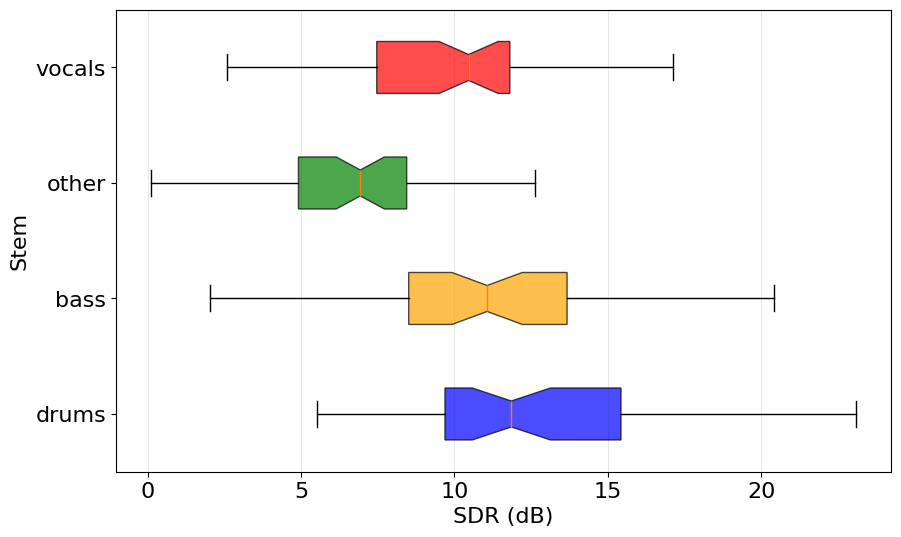

In [25]:
plot_sdr_results(sdr_collection, model)

## Motivation

In [72]:
def generate_new_mixture_with_original_stems(mix, device, stems_dict, target_stem, step, steps):
    """
    Generate a new mixture by adding up the original stems of the song and increasing
    the volume of the target stem linearly based on the step and steps.

    Args:
        mix (torch.Tensor): Original mixture tensor.
        device (torch.device): Device to run the computation on.
        stems_dict (dict): Dictionary containing the original stems of the song.
        target_stem (str): The stem to be enhanced in the new mixture.
        step (int): Current step in the progressive inference.
        steps (int): Total number of steps in the progressive inference.

    Returns:
        torch.Tensor: The new mixture tensor.
        float: Beta value indicating the proportion of the target stem in the new mixture.
    """
    new_mix = torch.zeros_like(mix)

    beta = step / steps

    for stem_name, waveform in stems_dict.items():
        if stem_name == target_stem:
            # Keep the target stem at normal volume
            new_mix += waveform.to(device)
        else:
            # Decrease the volume of other stems linearly
            new_mix += waveform.to(device) * (1-beta)


    tmp_mix = torch.zeros_like(mix)
    for stem_name, waveform in stems_dict.items():
        tmp_mix += waveform.to(device) 

    # calculate the loudness of tmp_mix
    loudness_tmp_mix = torch.mean(torch.abs(tmp_mix))

    # claculate the loudness of the mix
    loudness_mix = torch.mean(torch.abs(mix))

    print(f"Loudness of mix: {loudness_mix.item()}, Loudness of tmp_mix: {loudness_tmp_mix.item()}")

    # scale the new_mix to have the same loudness as the mix
    new_mix *= (loudness_mix / loudness_tmp_mix)

    return new_mix, beta

In [27]:
def schedule(initial_gains, step, steps, target_stem, schedule_type):
    """
    Create a schedule for all stems' gains except the target stem based on the specified schedule type.

    Args:
        initial_gains (dict): Dictionary of initial gains for each stem.
        step (int): The current step in the schedule.
        steps (int): The total number of steps in the schedule.
        target_stem (str): The stem to keep unchanged.
        schedule_type (str): The type of schedule ('linear', or 'constant').

    Returns:
        dict: Updated gains for each stem.
    """
    updated_gains = initial_gains.copy()

    for stem_name in updated_gains:
        if stem_name != target_stem:
            if schedule_type == "linear":
                # Linear decrease for non-target stems
                updated_gains[stem_name] = initial_gains[stem_name] * (1 - step / steps)
            elif schedule_type == "constant":
                # Constant gain for non-target stems
                updated_gains[stem_name] = initial_gains[stem_name]
            else:
                raise ValueError("Invalid schedule type. Choose from 'linear', or 'constant'.")
        # Target stem remains unchanged at its initial gain

    return updated_gains

In [93]:
def add_up_all_sources(model, mix, target_stem, initial_gains, steps, schedule_type, separated_sources, step):
    """
    Generate a new mixture based on the current step and schedule type.
    Args:
        model: The separation model.
        mix: The input mixture tensor (batch, channels, length).
        target_stem: The target stem to be enhanced.
        initial_gains: Initial gains for each stem.
        steps: Number of steps for progressive inference.
        schedule_type: Type of schedule ('linear', 'exponential', or 'constant').
        separated_sources: The separated sources tensor (batch, sources, channels, length).
        step: Current step in the schedule.
    Returns:
        new_mix: The new mixture tensor after applying the gains.
    """
    # update the gains based on the schedule
    gains = schedule(initial_gains, step, steps, target_stem=target_stem, schedule_type=schedule_type)

    beta = None

    # create the new mixture and apply the gains to the separated sources
    new_mix = torch.zeros_like(mix)
    for i, stem_name in enumerate(model.sources):
        new_mix += separated_sources[:, i] * gains[stem_name]
        if stem_name != target_stem and beta is None:
            beta = 1 - gains[stem_name]

    return new_mix, beta


In [29]:
def add_target_to_mixture(mix, separated_sources, index, step, steps):
    """
    Create a new mixture by applying a function inspired by diffusion models.
    This function progressively adds the target stem from the separated sources to the original mixture.
    The amount added is controlled by the step in the progressive inference.
    The new mixture is normalized to ensure it does not exceed the maximum amplitude.

    Args:
        mix (torch.Tensor): Original mixture tensor.
        separated_sources (torch.Tensor): Tensor of separated sources.
        index (int): Index of the target stem in the separated sources.
        step (int): Current step in the progressive inference.
        steps (int): Total number of steps.

    Returns:
        torch.Tensor: New mixture tensor.
        float: Beta value indicating the proportion of the target stem added to the mixture.
    """
    new_mix = torch.zeros_like(mix)
    beta = step / steps
    new_mix = mix * (1 - beta) + separated_sources[:, index] * beta
    
    return new_mix, beta


In [30]:
def wiener_filtering(separated_sources, reference_stem, stem_index):
    """
    Apply Wiener filtering to improve the separation of a target stem.

    Args:
        separated_sources (torch.Tensor): Tensor of separated sources (batch, sources, channels, length).
        reference_stem (torch.Tensor): Reference stem tensor (channels, length).
        stem_index (int): Index of the target stem in separated_sources.

    Returns:
        torch.Tensor: Tensor of the filtered target stem.
    """
    # Compute the accompaniment by subtracting the target stem from the reference stem
    accomp = (reference_stem - separated_sources[:, stem_index]).squeeze(0)

    # Extract the target stem
    separated_stem = separated_sources[:, stem_index].squeeze(0)

    # Perform STFT for each channel of the target and accompaniment
    target_spec_list = [librosa.stft(separated_stem[channel].cpu().numpy()).T for channel in range(separated_stem.shape[0])]
    accomp_spec_list = [librosa.stft(accomp[channel].cpu().numpy()).T for channel in range(accomp.shape[0])]

    # Compute magnitude and phase for the target and accompaniment
    target_mag = np.stack([np.abs(spec) for spec in target_spec_list], axis=-1)
    target_phase = np.stack([np.angle(spec) for spec in target_spec_list], axis=-1)
    accomp_mag = np.stack([np.abs(spec) for spec in accomp_spec_list], axis=-1)

    # Prepare inputs for Wiener filtering
    mix_spec = librosa.stft(reference_stem.cpu().numpy()).T
    sources = np.transpose(np.stack([target_mag, accomp_mag], axis=0), [1, 2, 3, 0])

    # Apply Wiener filtering
    specs = norbert.wiener(sources, mix_spec)

    # Reconstruct the target spectrogram with the original phase
    target_spec = np.abs(specs[:, :, :, 0]) * np.exp(1j * target_phase)

    # Perform inverse STFT for each channel
    pred_audio_list = [librosa.istft(target_spec[:, :, channel].T) for channel in range(target_spec.shape[2])]

    # Combine channels to create the stereo output
    pred_audio = np.stack(pred_audio_list, axis=-1).T

    # Convert the result to a tensor and adjust dimensions to match separated_sources
    pred_audio_tensor = torch.from_numpy(pred_audio).to(reference_stem.device).unsqueeze(0).unsqueeze(0)

    # Ensure compatibility with separated_sources dimensions
    if pred_audio_tensor.shape[2] != separated_sources.shape[2]:
        pred_audio_tensor = pred_audio_tensor.repeat(1, separated_sources.shape[2], 1)

    if pred_audio_tensor.shape[3] != separated_sources.shape[3]:
        if pred_audio_tensor.shape[3] < separated_sources.shape[3]:
            pred_audio_tensor = torch.nn.functional.pad(pred_audio_tensor, (0, separated_sources.shape[3] - pred_audio_tensor.shape[3]))
        else:
            pred_audio_tensor = pred_audio_tensor[:, :, :, :separated_sources.shape[3]]

    return pred_audio_tensor


In [95]:
def progressive_inference(
    model,
    mix,
    target_stem,
    reference_stems,
    initial_gains,
    sample_rate,
    mixture_update_mode="add sources",
    overlap=0.0, 
    device=None,
    normalize=True,
    wiener_filter=False,
    steps=10,
    schedule_type="linear",
    fix_clipping=True,
    display_output=False
):
    """
    Perform progressive inference on the mixture using the specified model and schedule.
    Args:
        model: The separation model.
        mix: The input mixture tensor (batch, channels, length).
        target_stem: The target stem to be enhanced.
        reference_stems: Dictionary of reference stems for evaluation.
        initial_gains: Initial gains for each stem.
        sample_rate: Sample rate of the audio.
        mixture_update_mode: Mode for updating the mixture ('add sources', 'add to mixture' or 'oracle predictor').
        overlap: Overlap between segments in seconds.
        device: Device to run the model on (CPU or GPU).
        normalize: Whether to normalize the input mixture.
        wiener_filter: Whether to apply Wiener filtering to the target stem.
        steps: Number of steps for progressive inference.
        schedule_type: Type of schedule ('linear', 'exponential', or 'constant').
        fix_clipping: Whether to fix audio clipping by normalizing the mixture.
        display_output: Whether to display the output audio tracks using IPython.display.
    Returns:
        separated_sources: The separated sources tensor (batch, sources, channels, length).
        sdr_results: List of dictionaries containing SDR results for each step.
    """

    sdr_results = []  # List to store SDR results for each step

    sdr_beta_results = []  # List to store SDR results for beta steps

    target_index = model.sources.index(target_stem)

    if device is None:
        device = mix.device
    else:
        device = torch.device(device)

    separated_sources = separate_sources(model, mix, sample_rate=sample_rate, overlap=overlap, device=device, normalize=normalize)

    if wiener_filter:
        print("Applying Wiener filtering...")
        separated_sources[:, target_index] = wiener_filtering(separated_sources, mix, target_index)

    # Compute SDR for the initial step
    initial_sdr_results = compute_sdrs(model, device, reference_stems, separated_sources)
    sdr_results.append(initial_sdr_results)

    initial_sdr_beta_results = compute_beta_sdrs(model, device, reference_stems, separated_sources, target_stem, 0.0)
    sdr_beta_results.append(initial_sdr_beta_results)

    # Progressive inference steps
    for step in range(1 , steps + 1): # start from 1 to steps inclusive
        # Update the mixture
        if mixture_update_mode == "oracle predictor":
            new_mix, beta = generate_new_mixture_with_original_stems(mix, device, reference_stems, target_stem, step, steps)
        elif mixture_update_mode == "add sources":
            new_mix, beta = add_up_all_sources(model, mix, target_stem, initial_gains, steps, schedule_type, separated_sources, step)
        elif mixture_update_mode == "add to mixture":
            new_mix, beta = add_target_to_mixture(mix, separated_sources, target_index, step, steps)
        else:
            raise ValueError("Invalid mixture update mode. Choose from 'add sources', 'add to mixture', or 'oracle predictor'.")
        
        # Check for clipping and raise error if detected
        max_amplitude = torch.max(torch.abs(new_mix))
        if max_amplitude > 1.0:
            if fix_clipping:  
                print(f"Audio clipping detected (max amplitude: {max_amplitude:.4f}). Normalizing to prevent distortion.")
                new_mix = new_mix / max_amplitude
            else:
                raise ValueError(f"Audio clipping detected (max amplitude: {max_amplitude:.4f}). Execution blocked to prevent distortion.")
            
        # Separate the new mixture
        separated_sources = separate_sources(model, new_mix, sample_rate=sample_rate, overlap=overlap, device=device, normalize=normalize)

        if wiener_filter:
            print("Applying Wiener filtering...")
            separated_sources[:, target_index] = wiener_filtering(separated_sources, new_mix, target_index)

        # Compute SDR for the current step
        step_sdr_results = compute_sdrs(model, device, reference_stems, separated_sources)
        sdr_results.append(step_sdr_results)

        step_sdr_beta_results = compute_beta_sdrs(model, device, reference_stems, separated_sources, target_stem, beta)
        sdr_beta_results.append(step_sdr_beta_results)

        if display_output:
            # display audio tracks in order to listen to the results using IPython.display
            print(f"Step {step}/{steps} - SDR Results:")
            for stem_name, sdr_value in step_sdr_results.items():
                print(f"{stem_name}: {sdr_value[0]:.2f} dB")
            print(f"Beta: {beta:.2f}")
            print("Playing the track:")
            ipd.display(ipd.Audio(mix[0, :, :].cpu().numpy(), rate=sample_rate, normalize=False))
            ipd.display(ipd.Audio(new_mix[0, :, :].cpu().numpy(), rate=sample_rate, normalize=False))
            ipd.display(ipd.Audio(separated_sources[0, target_index].cpu().numpy(), rate=sample_rate, normalize=False))
            ipd.display(ipd.Audio(reference_stems[target_stem], rate=sample_rate, normalize=False))


    return separated_sources, sdr_results, sdr_beta_results

In [84]:
def sdr_across_dataset(
    dataset_dict,
    model,
    sample_rate,
    device,
    normalize = False,
    overlap=0.0,
    target_stem="vocals",
    steps=10,
    mixture_update_mode="add sources",
    initial_gains=None,
    schedule_type="linear",
    wiener_filter=False,
    display_first_output=False,
):
    """
    Perform progressive inference across the dataset.
    Args:
        dataset_dict (dict): Dictionary containing the dataset.
        model: The separation model.
        sample_rate: Sample rate of the audio.
        device: Device to run the model on (CPU or GPU).
        normalize: Whether to normalize the input mixture.
        overlap: Overlap between segments in seconds.
        target_stem: The target stem to be enhanced.
        steps: Number of steps for progressive inference.
        mixture_update_mode: Mode for updating the mixture ('add sources' or 'add to mixture').
        initial_gains: Initial gains for each stem.
        schedule_type: Type of schedule ('linear', 'exponential', or 'constant').
        k: Parameter for the smooth transition function.
        wiener_filter: Whether to apply Wiener filtering to the target stem.
    Returns:
        average_sdr (dict): Dictionary containing the average SDR for each stem.
    """
    if initial_gains is None:
        initial_gains = {stem: 1 for stem in ["bass", "drums", "vocals", "other"]}

    sdr_collection_list = [] # tensor to store SDR results for each track
    sdr_beta_collection_list = [] # tensor to store beta SDR results for each track

    for track_name, stems_dict in tqdm(dataset_dict.items()):

        # Ensure the mixture exists in the stems
        if "new_mixture" not in stems_dict:
            print(f"Skipping track {track_name} as it does not contain a new mixture.")
            continue

        # Load the mixture and move it to the correct device
        mixture = stems_dict["new_mixture"].to(device).unsqueeze(0)  # Add batch dimension

        # if is the first track display output = True
        if display_first_output:
            display_output = True if track_name == list(dataset_dict.keys())[0] else False
        else:
            display_output = False
        
        # Perform progressive inference
        _ , sdr_results_single_track, sdr_beta_single_track = progressive_inference(
            model,
            mixture,
            target_stem,
            reference_stems=stems_dict,
            initial_gains=initial_gains,
            sample_rate=sample_rate,
            mixture_update_mode=mixture_update_mode,
            overlap=overlap, 
            device=device,
            normalize=normalize,
            wiener_filter=wiener_filter,
            steps=steps,
            schedule_type=schedule_type,
            display_output=display_output
        )

        # Convert sdr_results_single_track to a tensor
        sdr_tensor = torch.tensor([list(sdr_results_single_track[step].values()) for step in range(steps)]).squeeze(-1)

        # Append the SDR tensor to the collection
        sdr_collection_list.append(sdr_tensor)

        sdr_beta_tensor = torch.tensor([list(sdr_beta_single_track[step].values()) for step in range(steps)]).squeeze(-1)
        # Append the beta SDR tensor to the collection
        sdr_beta_collection_list.append(sdr_beta_tensor)
    
    # Evaluate the mean SDR for each stem
    sdr_collection = torch.stack(sdr_collection_list)
    sdr_collection_mean = torch.mean(sdr_collection, dim=0) 
    sdr_collection_std = torch.std(sdr_collection, dim=0)
    sdr_collection_min_max = torch.min(sdr_collection, dim=0).values, torch.max(sdr_collection, dim=0).values

    # Evaluate the mean beta SDR for each stem
    sdr_beta_collection = torch.stack(sdr_beta_collection_list)
    sdr_collection_mean_beta = torch.mean(sdr_beta_collection, dim=0)
    sdr_collection_std_beta = torch.std(sdr_beta_collection, dim=0)
    sdr_collection_min_max_beta = torch.min(sdr_beta_collection, dim=0).values, torch.max(sdr_beta_collection, dim=0).values

    
    return sdr_collection_mean , sdr_collection_std, sdr_collection_min_max, sdr_collection_mean_beta, sdr_collection_std_beta, sdr_collection_min_max_beta


In [33]:
# Plot the SDR results with min and max values using dashed lines
def plot_sdr_results(sdr_mean, sdr_min_max):
    """
    Plot the SDR results for each stem with min/max values as dashed lines.

    Args:
        sdr_mean (torch.Tensor): Mean SDR values for each stem (shape: [steps, stems]).
        sdr_min_max (tuple): Tuple of (min_values, max_values) tensors for each stem.
    Returns:
        None
    """

    # print average SDR results
    print("Average SDR results per stem:", sdr_mean)

    # Convert average_sdr tensor to a dictionary with numpy values
    average_sdr_dict = {
        "drums": sdr_mean[:, 0].cpu().numpy(),
        "bass": sdr_mean[:, 1].cpu().numpy(),
        "other": sdr_mean[:, 2].cpu().numpy(),
        "vocals": sdr_mean[:, 3].cpu().numpy()
    }

    # Convert min/max values
    sdr_min_max_dict = {
        "drums": (sdr_min_max[0][:, 0].cpu().numpy(), sdr_min_max[1][:, 0].cpu().numpy()),
        "bass": (sdr_min_max[0][:, 1].cpu().numpy(), sdr_min_max[1][:, 1].cpu().numpy()),
        "other": (sdr_min_max[0][:, 2].cpu().numpy(),sdr_min_max[1][:, 2].cpu().numpy()),
        "vocals": (sdr_min_max[0][:, 3].cpu().numpy(),sdr_min_max[1][:, 3].cpu().numpy())
    }

    steps = np.arange(1, len(average_sdr_dict["bass"]) + 1)

    plt.figure(figsize=(12, 6))
    colors = ['blue', 'orange', 'green', 'red']
    
    for stem, color in zip(average_sdr_dict.keys(), colors):
        plt.plot(steps, average_sdr_dict[stem], label=f"{stem.capitalize()} (mean)", 
                color=color, linewidth=2)
        
        plt.fill_between(
            steps,
            sdr_min_max_dict[stem][0],
            sdr_min_max_dict[stem][1],
            color=color,
            alpha=0.2
        )

    plt.xlabel('Steps')
    plt.ylabel('Average SDR (dB)')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


## Remixing with original stems (Oracle Predictor)

In [77]:
results = sdr_across_dataset(
    dataset_dict,
    model,
    sample_rate,
    device,
    overlap=0.0,  # No overlap
    target_stem="vocals",
    steps=10,
    mixture_update_mode="oracle predictor",  # Use oracle predictor for progressive inference
    display_first_output=False,  # Display output for the first track only
)

  0%|          | 0/50 [00:00<?, ?it/s]

Original loudness: 0.1283
Loudness of homogeneus mixture: 0.1280
Loudness of mix: 0.12834155559539795, Loudness of tmp_mix: 0.3850274682044983
Step 1/10 - Loudness of new mixture: 0.1165
Loudness of mix: 0.12834155559539795, Loudness of tmp_mix: 0.3850274682044983
Step 2/10 - Loudness of new mixture: 0.1047
Loudness of mix: 0.12834155559539795, Loudness of tmp_mix: 0.3850274682044983
Step 3/10 - Loudness of new mixture: 0.0930
Loudness of mix: 0.12834155559539795, Loudness of tmp_mix: 0.3850274682044983
Step 4/10 - Loudness of new mixture: 0.0812
Loudness of mix: 0.12834155559539795, Loudness of tmp_mix: 0.3850274682044983
Step 5/10 - Loudness of new mixture: 0.0696
Loudness of mix: 0.12834155559539795, Loudness of tmp_mix: 0.3850274682044983
Step 6/10 - Loudness of new mixture: 0.0580
Loudness of mix: 0.12834155559539795, Loudness of tmp_mix: 0.3850274682044983
Step 7/10 - Loudness of new mixture: 0.0466
Loudness of mix: 0.12834155559539795, Loudness of tmp_mix: 0.3850274682044983
Ste

  2%|▏         | 1/50 [00:05<04:36,  5.65s/it]

Original loudness: 0.0657
Loudness of homogeneus mixture: 0.0657
Loudness of mix: 0.06573797762393951, Loudness of tmp_mix: 0.1972152143716812
Step 1/10 - Loudness of new mixture: 0.0596
Loudness of mix: 0.06573797762393951, Loudness of tmp_mix: 0.1972152143716812
Step 2/10 - Loudness of new mixture: 0.0536
Loudness of mix: 0.06573797762393951, Loudness of tmp_mix: 0.1972152143716812
Step 3/10 - Loudness of new mixture: 0.0475
Loudness of mix: 0.06573797762393951, Loudness of tmp_mix: 0.1972152143716812
Step 4/10 - Loudness of new mixture: 0.0414
Loudness of mix: 0.06573797762393951, Loudness of tmp_mix: 0.1972152143716812
Step 5/10 - Loudness of new mixture: 0.0354
Loudness of mix: 0.06573797762393951, Loudness of tmp_mix: 0.1972152143716812
Step 6/10 - Loudness of new mixture: 0.0295
Loudness of mix: 0.06573797762393951, Loudness of tmp_mix: 0.1972152143716812
Step 7/10 - Loudness of new mixture: 0.0236
Loudness of mix: 0.06573797762393951, Loudness of tmp_mix: 0.1972152143716812
Ste

  4%|▍         | 2/50 [00:11<04:24,  5.52s/it]

Original loudness: 0.0731
Loudness of homogeneus mixture: 0.0731
Loudness of mix: 0.0731232687830925, Loudness of tmp_mix: 0.21937309205532074
Step 1/10 - Loudness of new mixture: 0.0666
Loudness of mix: 0.0731232687830925, Loudness of tmp_mix: 0.21937309205532074
Step 2/10 - Loudness of new mixture: 0.0601
Loudness of mix: 0.0731232687830925, Loudness of tmp_mix: 0.21937309205532074
Step 3/10 - Loudness of new mixture: 0.0536
Loudness of mix: 0.0731232687830925, Loudness of tmp_mix: 0.21937309205532074
Step 4/10 - Loudness of new mixture: 0.0472
Loudness of mix: 0.0731232687830925, Loudness of tmp_mix: 0.21937309205532074
Step 5/10 - Loudness of new mixture: 0.0408
Loudness of mix: 0.0731232687830925, Loudness of tmp_mix: 0.21937309205532074
Step 6/10 - Loudness of new mixture: 0.0344
Loudness of mix: 0.0731232687830925, Loudness of tmp_mix: 0.21937309205532074
Step 7/10 - Loudness of new mixture: 0.0282
Loudness of mix: 0.0731232687830925, Loudness of tmp_mix: 0.21937309205532074
Ste

  6%|▌         | 3/50 [00:16<04:17,  5.48s/it]

Original loudness: 0.0888
Loudness of homogeneus mixture: 0.0888
Loudness of mix: 0.08883223682641983, Loudness of tmp_mix: 0.26650020480155945
Step 1/10 - Loudness of new mixture: 0.0802
Loudness of mix: 0.08883223682641983, Loudness of tmp_mix: 0.26650020480155945
Step 2/10 - Loudness of new mixture: 0.0716
Loudness of mix: 0.08883223682641983, Loudness of tmp_mix: 0.26650020480155945
Step 3/10 - Loudness of new mixture: 0.0629
Loudness of mix: 0.08883223682641983, Loudness of tmp_mix: 0.26650020480155945
Step 4/10 - Loudness of new mixture: 0.0543
Loudness of mix: 0.08883223682641983, Loudness of tmp_mix: 0.26650020480155945
Step 5/10 - Loudness of new mixture: 0.0457
Loudness of mix: 0.08883223682641983, Loudness of tmp_mix: 0.26650020480155945
Step 6/10 - Loudness of new mixture: 0.0371
Loudness of mix: 0.08883223682641983, Loudness of tmp_mix: 0.26650020480155945
Step 7/10 - Loudness of new mixture: 0.0286
Loudness of mix: 0.08883223682641983, Loudness of tmp_mix: 0.2665002048015

  8%|▊         | 4/50 [00:21<04:10,  5.46s/it]

Original loudness: 0.0313
Loudness of homogeneus mixture: 0.0314
Loudness of mix: 0.031349580734968185, Loudness of tmp_mix: 0.09405043721199036
Step 1/10 - Loudness of new mixture: 0.0288
Loudness of mix: 0.031349580734968185, Loudness of tmp_mix: 0.09405043721199036
Step 2/10 - Loudness of new mixture: 0.0263
Loudness of mix: 0.031349580734968185, Loudness of tmp_mix: 0.09405043721199036
Step 3/10 - Loudness of new mixture: 0.0238
Loudness of mix: 0.031349580734968185, Loudness of tmp_mix: 0.09405043721199036
Step 4/10 - Loudness of new mixture: 0.0212
Loudness of mix: 0.031349580734968185, Loudness of tmp_mix: 0.09405043721199036
Step 5/10 - Loudness of new mixture: 0.0187
Loudness of mix: 0.031349580734968185, Loudness of tmp_mix: 0.09405043721199036
Step 6/10 - Loudness of new mixture: 0.0162
Loudness of mix: 0.031349580734968185, Loudness of tmp_mix: 0.09405043721199036
Step 7/10 - Loudness of new mixture: 0.0138
Loudness of mix: 0.031349580734968185, Loudness of tmp_mix: 0.09405

 10%|█         | 5/50 [00:27<04:04,  5.44s/it]

Original loudness: 0.0692
Loudness of homogeneus mixture: 0.0690
Loudness of mix: 0.06917960196733475, Loudness of tmp_mix: 0.2075423300266266
Step 1/10 - Loudness of new mixture: 0.0632
Loudness of mix: 0.06917960196733475, Loudness of tmp_mix: 0.2075423300266266
Step 2/10 - Loudness of new mixture: 0.0572
Loudness of mix: 0.06917960196733475, Loudness of tmp_mix: 0.2075423300266266
Step 3/10 - Loudness of new mixture: 0.0512
Loudness of mix: 0.06917960196733475, Loudness of tmp_mix: 0.2075423300266266
Step 4/10 - Loudness of new mixture: 0.0453
Loudness of mix: 0.06917960196733475, Loudness of tmp_mix: 0.2075423300266266
Step 5/10 - Loudness of new mixture: 0.0393
Loudness of mix: 0.06917960196733475, Loudness of tmp_mix: 0.2075423300266266
Step 6/10 - Loudness of new mixture: 0.0335
Loudness of mix: 0.06917960196733475, Loudness of tmp_mix: 0.2075423300266266
Step 7/10 - Loudness of new mixture: 0.0277
Loudness of mix: 0.06917960196733475, Loudness of tmp_mix: 0.2075423300266266
Ste

 12%|█▏        | 6/50 [00:32<03:59,  5.44s/it]

Original loudness: 0.0960
Loudness of homogeneus mixture: 0.0960
Loudness of mix: 0.09598968178033829, Loudness of tmp_mix: 0.2879710793495178
Step 1/10 - Loudness of new mixture: 0.0871
Loudness of mix: 0.09598968178033829, Loudness of tmp_mix: 0.2879710793495178
Step 2/10 - Loudness of new mixture: 0.0783
Loudness of mix: 0.09598968178033829, Loudness of tmp_mix: 0.2879710793495178
Step 3/10 - Loudness of new mixture: 0.0694
Loudness of mix: 0.09598968178033829, Loudness of tmp_mix: 0.2879710793495178
Step 4/10 - Loudness of new mixture: 0.0606
Loudness of mix: 0.09598968178033829, Loudness of tmp_mix: 0.2879710793495178
Step 5/10 - Loudness of new mixture: 0.0518
Loudness of mix: 0.09598968178033829, Loudness of tmp_mix: 0.2879710793495178
Step 6/10 - Loudness of new mixture: 0.0432
Loudness of mix: 0.09598968178033829, Loudness of tmp_mix: 0.2879710793495178
Step 7/10 - Loudness of new mixture: 0.0346
Loudness of mix: 0.09598968178033829, Loudness of tmp_mix: 0.2879710793495178
Ste

 14%|█▍        | 7/50 [00:38<03:53,  5.43s/it]

Original loudness: 0.0950
Loudness of homogeneus mixture: 0.0950
Loudness of mix: 0.09502003341913223, Loudness of tmp_mix: 0.2850612998008728
Step 1/10 - Loudness of new mixture: 0.0861
Loudness of mix: 0.09502003341913223, Loudness of tmp_mix: 0.2850612998008728
Step 2/10 - Loudness of new mixture: 0.0772
Loudness of mix: 0.09502003341913223, Loudness of tmp_mix: 0.2850612998008728
Step 3/10 - Loudness of new mixture: 0.0683
Loudness of mix: 0.09502003341913223, Loudness of tmp_mix: 0.2850612998008728
Step 4/10 - Loudness of new mixture: 0.0595
Loudness of mix: 0.09502003341913223, Loudness of tmp_mix: 0.2850612998008728
Step 5/10 - Loudness of new mixture: 0.0507
Loudness of mix: 0.09502003341913223, Loudness of tmp_mix: 0.2850612998008728
Step 6/10 - Loudness of new mixture: 0.0419
Loudness of mix: 0.09502003341913223, Loudness of tmp_mix: 0.2850612998008728
Step 7/10 - Loudness of new mixture: 0.0333
Loudness of mix: 0.09502003341913223, Loudness of tmp_mix: 0.2850612998008728
Ste

 16%|█▌        | 8/50 [00:43<03:48,  5.43s/it]

Original loudness: 0.1089
Loudness of homogeneus mixture: 0.1088
Loudness of mix: 0.10891205072402954, Loudness of tmp_mix: 0.3267363905906677
Step 1/10 - Loudness of new mixture: 0.0988
Loudness of mix: 0.10891205072402954, Loudness of tmp_mix: 0.3267363905906677
Step 2/10 - Loudness of new mixture: 0.0888
Loudness of mix: 0.10891205072402954, Loudness of tmp_mix: 0.3267363905906677
Step 3/10 - Loudness of new mixture: 0.0787
Loudness of mix: 0.10891205072402954, Loudness of tmp_mix: 0.3267363905906677
Step 4/10 - Loudness of new mixture: 0.0688
Loudness of mix: 0.10891205072402954, Loudness of tmp_mix: 0.3267363905906677
Step 5/10 - Loudness of new mixture: 0.0588
Loudness of mix: 0.10891205072402954, Loudness of tmp_mix: 0.3267363905906677
Step 6/10 - Loudness of new mixture: 0.0490
Loudness of mix: 0.10891205072402954, Loudness of tmp_mix: 0.3267363905906677
Step 7/10 - Loudness of new mixture: 0.0393
Loudness of mix: 0.10891205072402954, Loudness of tmp_mix: 0.3267363905906677
Ste

 18%|█▊        | 9/50 [00:49<03:42,  5.43s/it]

Original loudness: 0.0986
Loudness of homogeneus mixture: 0.0985
Loudness of mix: 0.09864401072263718, Loudness of tmp_mix: 0.2959345281124115
Step 1/10 - Loudness of new mixture: 0.0896
Loudness of mix: 0.09864401072263718, Loudness of tmp_mix: 0.2959345281124115
Step 2/10 - Loudness of new mixture: 0.0805
Loudness of mix: 0.09864401072263718, Loudness of tmp_mix: 0.2959345281124115
Step 3/10 - Loudness of new mixture: 0.0715
Loudness of mix: 0.09864401072263718, Loudness of tmp_mix: 0.2959345281124115
Step 4/10 - Loudness of new mixture: 0.0626
Loudness of mix: 0.09864401072263718, Loudness of tmp_mix: 0.2959345281124115
Step 5/10 - Loudness of new mixture: 0.0536
Loudness of mix: 0.09864401072263718, Loudness of tmp_mix: 0.2959345281124115
Step 6/10 - Loudness of new mixture: 0.0448
Loudness of mix: 0.09864401072263718, Loudness of tmp_mix: 0.2959345281124115
Step 7/10 - Loudness of new mixture: 0.0361
Loudness of mix: 0.09864401072263718, Loudness of tmp_mix: 0.2959345281124115
Ste

 20%|██        | 10/50 [00:54<03:38,  5.46s/it]

Original loudness: 0.0670
Loudness of homogeneus mixture: 0.0669
Loudness of mix: 0.0669776052236557, Loudness of tmp_mix: 0.200935497879982
Step 1/10 - Loudness of new mixture: 0.0606
Loudness of mix: 0.0669776052236557, Loudness of tmp_mix: 0.200935497879982
Step 2/10 - Loudness of new mixture: 0.0543
Loudness of mix: 0.0669776052236557, Loudness of tmp_mix: 0.200935497879982
Step 3/10 - Loudness of new mixture: 0.0480
Loudness of mix: 0.0669776052236557, Loudness of tmp_mix: 0.200935497879982
Step 4/10 - Loudness of new mixture: 0.0417
Loudness of mix: 0.0669776052236557, Loudness of tmp_mix: 0.200935497879982
Step 5/10 - Loudness of new mixture: 0.0355
Loudness of mix: 0.0669776052236557, Loudness of tmp_mix: 0.200935497879982
Step 6/10 - Loudness of new mixture: 0.0293
Loudness of mix: 0.0669776052236557, Loudness of tmp_mix: 0.200935497879982
Step 7/10 - Loudness of new mixture: 0.0232
Loudness of mix: 0.0669776052236557, Loudness of tmp_mix: 0.200935497879982
Step 8/10 - Loudnes

 22%|██▏       | 11/50 [01:00<03:33,  5.47s/it]

Original loudness: 0.1007
Loudness of homogeneus mixture: 0.1008
Loudness of mix: 0.10072074830532074, Loudness of tmp_mix: 0.30216288566589355
Step 1/10 - Loudness of new mixture: 0.0920
Loudness of mix: 0.10072074830532074, Loudness of tmp_mix: 0.30216288566589355
Step 2/10 - Loudness of new mixture: 0.0833
Loudness of mix: 0.10072074830532074, Loudness of tmp_mix: 0.30216288566589355
Step 3/10 - Loudness of new mixture: 0.0747
Loudness of mix: 0.10072074830532074, Loudness of tmp_mix: 0.30216288566589355
Step 4/10 - Loudness of new mixture: 0.0661
Loudness of mix: 0.10072074830532074, Loudness of tmp_mix: 0.30216288566589355
Step 5/10 - Loudness of new mixture: 0.0576
Loudness of mix: 0.10072074830532074, Loudness of tmp_mix: 0.30216288566589355
Step 6/10 - Loudness of new mixture: 0.0491
Loudness of mix: 0.10072074830532074, Loudness of tmp_mix: 0.30216288566589355
Step 7/10 - Loudness of new mixture: 0.0409
Loudness of mix: 0.10072074830532074, Loudness of tmp_mix: 0.3021628856658

 24%|██▍       | 12/50 [01:05<03:27,  5.45s/it]

Original loudness: 0.0798
Loudness of homogeneus mixture: 0.0796
Loudness of mix: 0.07976862788200378, Loudness of tmp_mix: 0.239308163523674
Step 1/10 - Loudness of new mixture: 0.0727
Loudness of mix: 0.07976862788200378, Loudness of tmp_mix: 0.239308163523674
Step 2/10 - Loudness of new mixture: 0.0657
Loudness of mix: 0.07976862788200378, Loudness of tmp_mix: 0.239308163523674
Step 3/10 - Loudness of new mixture: 0.0587
Loudness of mix: 0.07976862788200378, Loudness of tmp_mix: 0.239308163523674
Step 4/10 - Loudness of new mixture: 0.0517
Loudness of mix: 0.07976862788200378, Loudness of tmp_mix: 0.239308163523674
Step 5/10 - Loudness of new mixture: 0.0448
Loudness of mix: 0.07976862788200378, Loudness of tmp_mix: 0.239308163523674
Step 6/10 - Loudness of new mixture: 0.0379
Loudness of mix: 0.07976862788200378, Loudness of tmp_mix: 0.239308163523674
Step 7/10 - Loudness of new mixture: 0.0311
Loudness of mix: 0.07976862788200378, Loudness of tmp_mix: 0.239308163523674
Step 8/10 -

 26%|██▌       | 13/50 [01:10<03:21,  5.44s/it]

Original loudness: 0.1018
Loudness of homogeneus mixture: 0.1015
Loudness of mix: 0.10178019106388092, Loudness of tmp_mix: 0.30534201860427856
Step 1/10 - Loudness of new mixture: 0.0919
Loudness of mix: 0.10178019106388092, Loudness of tmp_mix: 0.30534201860427856
Step 2/10 - Loudness of new mixture: 0.0821
Loudness of mix: 0.10178019106388092, Loudness of tmp_mix: 0.30534201860427856
Step 3/10 - Loudness of new mixture: 0.0723
Loudness of mix: 0.10178019106388092, Loudness of tmp_mix: 0.30534201860427856
Step 4/10 - Loudness of new mixture: 0.0625
Loudness of mix: 0.10178019106388092, Loudness of tmp_mix: 0.30534201860427856
Step 5/10 - Loudness of new mixture: 0.0528
Loudness of mix: 0.10178019106388092, Loudness of tmp_mix: 0.30534201860427856
Step 6/10 - Loudness of new mixture: 0.0430
Loudness of mix: 0.10178019106388092, Loudness of tmp_mix: 0.30534201860427856
Step 7/10 - Loudness of new mixture: 0.0334
Loudness of mix: 0.10178019106388092, Loudness of tmp_mix: 0.3053420186042

 28%|██▊       | 14/50 [01:16<03:15,  5.43s/it]

Original loudness: 0.0853
Loudness of homogeneus mixture: 0.0854
Loudness of mix: 0.08529622852802277, Loudness of tmp_mix: 0.2558920681476593
Step 1/10 - Loudness of new mixture: 0.0776
Loudness of mix: 0.08529622852802277, Loudness of tmp_mix: 0.2558920681476593
Step 2/10 - Loudness of new mixture: 0.0698
Loudness of mix: 0.08529622852802277, Loudness of tmp_mix: 0.2558920681476593
Step 3/10 - Loudness of new mixture: 0.0621
Loudness of mix: 0.08529622852802277, Loudness of tmp_mix: 0.2558920681476593
Step 4/10 - Loudness of new mixture: 0.0545
Loudness of mix: 0.08529622852802277, Loudness of tmp_mix: 0.2558920681476593
Step 5/10 - Loudness of new mixture: 0.0468
Loudness of mix: 0.08529622852802277, Loudness of tmp_mix: 0.2558920681476593
Step 6/10 - Loudness of new mixture: 0.0392
Loudness of mix: 0.08529622852802277, Loudness of tmp_mix: 0.2558920681476593
Step 7/10 - Loudness of new mixture: 0.0317
Loudness of mix: 0.08529622852802277, Loudness of tmp_mix: 0.2558920681476593
Ste

 30%|███       | 15/50 [01:21<03:10,  5.43s/it]

Original loudness: 0.1287
Loudness of homogeneus mixture: 0.1285
Loudness of mix: 0.1286526918411255, Loudness of tmp_mix: 0.38596007227897644
Step 1/10 - Loudness of new mixture: 0.1162
Loudness of mix: 0.1286526918411255, Loudness of tmp_mix: 0.38596007227897644
Step 2/10 - Loudness of new mixture: 0.1038
Loudness of mix: 0.1286526918411255, Loudness of tmp_mix: 0.38596007227897644
Step 3/10 - Loudness of new mixture: 0.0913
Loudness of mix: 0.1286526918411255, Loudness of tmp_mix: 0.38596007227897644
Step 4/10 - Loudness of new mixture: 0.0790
Loudness of mix: 0.1286526918411255, Loudness of tmp_mix: 0.38596007227897644
Step 5/10 - Loudness of new mixture: 0.0666
Loudness of mix: 0.1286526918411255, Loudness of tmp_mix: 0.38596007227897644
Step 6/10 - Loudness of new mixture: 0.0543
Loudness of mix: 0.1286526918411255, Loudness of tmp_mix: 0.38596007227897644
Step 7/10 - Loudness of new mixture: 0.0422
Loudness of mix: 0.1286526918411255, Loudness of tmp_mix: 0.38596007227897644
Ste

 32%|███▏      | 16/50 [01:27<03:04,  5.43s/it]

Original loudness: 0.0826
Loudness of homogeneus mixture: 0.0826
Loudness of mix: 0.08256859332323074, Loudness of tmp_mix: 0.24770809710025787
Step 1/10 - Loudness of new mixture: 0.0751
Loudness of mix: 0.08256859332323074, Loudness of tmp_mix: 0.24770809710025787
Step 2/10 - Loudness of new mixture: 0.0676
Loudness of mix: 0.08256859332323074, Loudness of tmp_mix: 0.24770809710025787
Step 3/10 - Loudness of new mixture: 0.0601
Loudness of mix: 0.08256859332323074, Loudness of tmp_mix: 0.24770809710025787
Step 4/10 - Loudness of new mixture: 0.0527
Loudness of mix: 0.08256859332323074, Loudness of tmp_mix: 0.24770809710025787
Step 5/10 - Loudness of new mixture: 0.0453
Loudness of mix: 0.08256859332323074, Loudness of tmp_mix: 0.24770809710025787
Step 6/10 - Loudness of new mixture: 0.0380
Loudness of mix: 0.08256859332323074, Loudness of tmp_mix: 0.24770809710025787
Step 7/10 - Loudness of new mixture: 0.0307
Loudness of mix: 0.08256859332323074, Loudness of tmp_mix: 0.2477080971002

 34%|███▍      | 17/50 [01:32<02:58,  5.42s/it]

Original loudness: 0.1162
Loudness of homogeneus mixture: 0.1162
Loudness of mix: 0.11623772978782654, Loudness of tmp_mix: 0.3487166464328766
Step 1/10 - Loudness of new mixture: 0.1052
Loudness of mix: 0.11623772978782654, Loudness of tmp_mix: 0.3487166464328766
Step 2/10 - Loudness of new mixture: 0.0943
Loudness of mix: 0.11623772978782654, Loudness of tmp_mix: 0.3487166464328766
Step 3/10 - Loudness of new mixture: 0.0833
Loudness of mix: 0.11623772978782654, Loudness of tmp_mix: 0.3487166464328766
Step 4/10 - Loudness of new mixture: 0.0724
Loudness of mix: 0.11623772978782654, Loudness of tmp_mix: 0.3487166464328766
Step 5/10 - Loudness of new mixture: 0.0615
Loudness of mix: 0.11623772978782654, Loudness of tmp_mix: 0.3487166464328766
Step 6/10 - Loudness of new mixture: 0.0507
Loudness of mix: 0.11623772978782654, Loudness of tmp_mix: 0.3487166464328766
Step 7/10 - Loudness of new mixture: 0.0399
Loudness of mix: 0.11623772978782654, Loudness of tmp_mix: 0.3487166464328766
Ste

 36%|███▌      | 18/50 [01:37<02:53,  5.42s/it]

Original loudness: 0.1082
Loudness of homogeneus mixture: 0.1077
Loudness of mix: 0.10824031382799149, Loudness of tmp_mix: 0.3247241675853729
Step 1/10 - Loudness of new mixture: 0.0983
Loudness of mix: 0.10824031382799149, Loudness of tmp_mix: 0.3247241675853729
Step 2/10 - Loudness of new mixture: 0.0883
Loudness of mix: 0.10824031382799149, Loudness of tmp_mix: 0.3247241675853729
Step 3/10 - Loudness of new mixture: 0.0784
Loudness of mix: 0.10824031382799149, Loudness of tmp_mix: 0.3247241675853729
Step 4/10 - Loudness of new mixture: 0.0685
Loudness of mix: 0.10824031382799149, Loudness of tmp_mix: 0.3247241675853729
Step 5/10 - Loudness of new mixture: 0.0587
Loudness of mix: 0.10824031382799149, Loudness of tmp_mix: 0.3247241675853729
Step 6/10 - Loudness of new mixture: 0.0490
Loudness of mix: 0.10824031382799149, Loudness of tmp_mix: 0.3247241675853729
Step 7/10 - Loudness of new mixture: 0.0395
Loudness of mix: 0.10824031382799149, Loudness of tmp_mix: 0.3247241675853729
Ste

 38%|███▊      | 19/50 [01:43<02:47,  5.42s/it]

Original loudness: 0.0876
Loudness of homogeneus mixture: 0.0875
Loudness of mix: 0.08763237297534943, Loudness of tmp_mix: 0.26290062069892883
Step 1/10 - Loudness of new mixture: 0.0800
Loudness of mix: 0.08763237297534943, Loudness of tmp_mix: 0.26290062069892883
Step 2/10 - Loudness of new mixture: 0.0723
Loudness of mix: 0.08763237297534943, Loudness of tmp_mix: 0.26290062069892883
Step 3/10 - Loudness of new mixture: 0.0647
Loudness of mix: 0.08763237297534943, Loudness of tmp_mix: 0.26290062069892883
Step 4/10 - Loudness of new mixture: 0.0571
Loudness of mix: 0.08763237297534943, Loudness of tmp_mix: 0.26290062069892883
Step 5/10 - Loudness of new mixture: 0.0496
Loudness of mix: 0.08763237297534943, Loudness of tmp_mix: 0.26290062069892883
Step 6/10 - Loudness of new mixture: 0.0421
Loudness of mix: 0.08763237297534943, Loudness of tmp_mix: 0.26290062069892883
Step 7/10 - Loudness of new mixture: 0.0348
Loudness of mix: 0.08763237297534943, Loudness of tmp_mix: 0.2629006206989

 40%|████      | 20/50 [01:48<02:42,  5.41s/it]

Original loudness: 0.0708
Loudness of homogeneus mixture: 0.0707
Loudness of mix: 0.07080232352018356, Loudness of tmp_mix: 0.21240776777267456
Step 1/10 - Loudness of new mixture: 0.0647
Loudness of mix: 0.07080232352018356, Loudness of tmp_mix: 0.21240776777267456
Step 2/10 - Loudness of new mixture: 0.0585
Loudness of mix: 0.07080232352018356, Loudness of tmp_mix: 0.21240776777267456
Step 3/10 - Loudness of new mixture: 0.0524
Loudness of mix: 0.07080232352018356, Loudness of tmp_mix: 0.21240776777267456
Step 4/10 - Loudness of new mixture: 0.0463
Loudness of mix: 0.07080232352018356, Loudness of tmp_mix: 0.21240776777267456
Step 5/10 - Loudness of new mixture: 0.0403
Loudness of mix: 0.07080232352018356, Loudness of tmp_mix: 0.21240776777267456
Step 6/10 - Loudness of new mixture: 0.0343
Loudness of mix: 0.07080232352018356, Loudness of tmp_mix: 0.21240776777267456
Step 7/10 - Loudness of new mixture: 0.0284
Loudness of mix: 0.07080232352018356, Loudness of tmp_mix: 0.2124077677726

 42%|████▏     | 21/50 [01:54<02:36,  5.41s/it]

Original loudness: 0.0888
Loudness of homogeneus mixture: 0.0883
Loudness of mix: 0.08875088393688202, Loudness of tmp_mix: 0.266254723072052
Step 1/10 - Loudness of new mixture: 0.0803
Loudness of mix: 0.08875088393688202, Loudness of tmp_mix: 0.266254723072052
Step 2/10 - Loudness of new mixture: 0.0719
Loudness of mix: 0.08875088393688202, Loudness of tmp_mix: 0.266254723072052
Step 3/10 - Loudness of new mixture: 0.0635
Loudness of mix: 0.08875088393688202, Loudness of tmp_mix: 0.266254723072052
Step 4/10 - Loudness of new mixture: 0.0551
Loudness of mix: 0.08875088393688202, Loudness of tmp_mix: 0.266254723072052
Step 5/10 - Loudness of new mixture: 0.0468
Loudness of mix: 0.08875088393688202, Loudness of tmp_mix: 0.266254723072052
Step 6/10 - Loudness of new mixture: 0.0385
Loudness of mix: 0.08875088393688202, Loudness of tmp_mix: 0.266254723072052
Step 7/10 - Loudness of new mixture: 0.0303
Loudness of mix: 0.08875088393688202, Loudness of tmp_mix: 0.266254723072052
Step 8/10 -

 44%|████▍     | 22/50 [01:59<02:31,  5.41s/it]

Original loudness: 0.0881
Loudness of homogeneus mixture: 0.0879
Loudness of mix: 0.08810099214315414, Loudness of tmp_mix: 0.2643031179904938
Step 1/10 - Loudness of new mixture: 0.0796
Loudness of mix: 0.08810099214315414, Loudness of tmp_mix: 0.2643031179904938
Step 2/10 - Loudness of new mixture: 0.0710
Loudness of mix: 0.08810099214315414, Loudness of tmp_mix: 0.2643031179904938
Step 3/10 - Loudness of new mixture: 0.0625
Loudness of mix: 0.08810099214315414, Loudness of tmp_mix: 0.2643031179904938
Step 4/10 - Loudness of new mixture: 0.0540
Loudness of mix: 0.08810099214315414, Loudness of tmp_mix: 0.2643031179904938
Step 5/10 - Loudness of new mixture: 0.0456
Loudness of mix: 0.08810099214315414, Loudness of tmp_mix: 0.2643031179904938
Step 6/10 - Loudness of new mixture: 0.0371
Loudness of mix: 0.08810099214315414, Loudness of tmp_mix: 0.2643031179904938
Step 7/10 - Loudness of new mixture: 0.0288
Loudness of mix: 0.08810099214315414, Loudness of tmp_mix: 0.2643031179904938
Ste

 46%|████▌     | 23/50 [02:05<02:26,  5.41s/it]

Original loudness: 0.0732
Loudness of homogeneus mixture: 0.0729
Loudness of mix: 0.07316271960735321, Loudness of tmp_mix: 0.2194894701242447
Step 1/10 - Loudness of new mixture: 0.0667
Loudness of mix: 0.07316271960735321, Loudness of tmp_mix: 0.2194894701242447
Step 2/10 - Loudness of new mixture: 0.0602
Loudness of mix: 0.07316271960735321, Loudness of tmp_mix: 0.2194894701242447
Step 3/10 - Loudness of new mixture: 0.0538
Loudness of mix: 0.07316271960735321, Loudness of tmp_mix: 0.2194894701242447
Step 4/10 - Loudness of new mixture: 0.0473
Loudness of mix: 0.07316271960735321, Loudness of tmp_mix: 0.2194894701242447
Step 5/10 - Loudness of new mixture: 0.0410
Loudness of mix: 0.07316271960735321, Loudness of tmp_mix: 0.2194894701242447
Step 6/10 - Loudness of new mixture: 0.0346
Loudness of mix: 0.07316271960735321, Loudness of tmp_mix: 0.2194894701242447
Step 7/10 - Loudness of new mixture: 0.0284
Loudness of mix: 0.07316271960735321, Loudness of tmp_mix: 0.2194894701242447
Ste

 48%|████▊     | 24/50 [02:10<02:20,  5.41s/it]

Original loudness: 0.0848
Loudness of homogeneus mixture: 0.0849
Loudness of mix: 0.08484839648008347, Loudness of tmp_mix: 0.2545473873615265
Step 1/10 - Loudness of new mixture: 0.0769
Loudness of mix: 0.08484839648008347, Loudness of tmp_mix: 0.2545473873615265
Step 2/10 - Loudness of new mixture: 0.0690
Loudness of mix: 0.08484839648008347, Loudness of tmp_mix: 0.2545473873615265
Step 3/10 - Loudness of new mixture: 0.0611
Loudness of mix: 0.08484839648008347, Loudness of tmp_mix: 0.2545473873615265
Step 4/10 - Loudness of new mixture: 0.0533
Loudness of mix: 0.08484839648008347, Loudness of tmp_mix: 0.2545473873615265
Step 5/10 - Loudness of new mixture: 0.0454
Loudness of mix: 0.08484839648008347, Loudness of tmp_mix: 0.2545473873615265
Step 6/10 - Loudness of new mixture: 0.0377
Loudness of mix: 0.08484839648008347, Loudness of tmp_mix: 0.2545473873615265
Step 7/10 - Loudness of new mixture: 0.0301
Loudness of mix: 0.08484839648008347, Loudness of tmp_mix: 0.2545473873615265
Ste

 50%|█████     | 25/50 [02:15<02:15,  5.41s/it]

Original loudness: 0.1041
Loudness of homogeneus mixture: 0.1041
Loudness of mix: 0.10408666729927063, Loudness of tmp_mix: 0.3122601807117462
Step 1/10 - Loudness of new mixture: 0.0944
Loudness of mix: 0.10408666729927063, Loudness of tmp_mix: 0.3122601807117462
Step 2/10 - Loudness of new mixture: 0.0848
Loudness of mix: 0.10408666729927063, Loudness of tmp_mix: 0.3122601807117462
Step 3/10 - Loudness of new mixture: 0.0752
Loudness of mix: 0.10408666729927063, Loudness of tmp_mix: 0.3122601807117462
Step 4/10 - Loudness of new mixture: 0.0656
Loudness of mix: 0.10408666729927063, Loudness of tmp_mix: 0.3122601807117462
Step 5/10 - Loudness of new mixture: 0.0560
Loudness of mix: 0.10408666729927063, Loudness of tmp_mix: 0.3122601807117462
Step 6/10 - Loudness of new mixture: 0.0465
Loudness of mix: 0.10408666729927063, Loudness of tmp_mix: 0.3122601807117462
Step 7/10 - Loudness of new mixture: 0.0370
Loudness of mix: 0.10408666729927063, Loudness of tmp_mix: 0.3122601807117462
Ste

 52%|█████▏    | 26/50 [02:21<02:09,  5.41s/it]

Original loudness: 0.1072
Loudness of homogeneus mixture: 0.1071
Loudness of mix: 0.10724445432424545, Loudness of tmp_mix: 0.3217359185218811
Step 1/10 - Loudness of new mixture: 0.0973
Loudness of mix: 0.10724445432424545, Loudness of tmp_mix: 0.3217359185218811
Step 2/10 - Loudness of new mixture: 0.0874
Loudness of mix: 0.10724445432424545, Loudness of tmp_mix: 0.3217359185218811
Step 3/10 - Loudness of new mixture: 0.0774
Loudness of mix: 0.10724445432424545, Loudness of tmp_mix: 0.3217359185218811
Step 4/10 - Loudness of new mixture: 0.0676
Loudness of mix: 0.10724445432424545, Loudness of tmp_mix: 0.3217359185218811
Step 5/10 - Loudness of new mixture: 0.0578
Loudness of mix: 0.10724445432424545, Loudness of tmp_mix: 0.3217359185218811
Step 6/10 - Loudness of new mixture: 0.0480
Loudness of mix: 0.10724445432424545, Loudness of tmp_mix: 0.3217359185218811
Step 7/10 - Loudness of new mixture: 0.0384
Loudness of mix: 0.10724445432424545, Loudness of tmp_mix: 0.3217359185218811
Ste

 54%|█████▍    | 27/50 [02:26<02:04,  5.41s/it]

Original loudness: 0.1066
Loudness of homogeneus mixture: 0.1065
Loudness of mix: 0.10658067464828491, Loudness of tmp_mix: 0.319745808839798
Step 1/10 - Loudness of new mixture: 0.0966
Loudness of mix: 0.10658067464828491, Loudness of tmp_mix: 0.319745808839798
Step 2/10 - Loudness of new mixture: 0.0866
Loudness of mix: 0.10658067464828491, Loudness of tmp_mix: 0.319745808839798
Step 3/10 - Loudness of new mixture: 0.0766
Loudness of mix: 0.10658067464828491, Loudness of tmp_mix: 0.319745808839798
Step 4/10 - Loudness of new mixture: 0.0667
Loudness of mix: 0.10658067464828491, Loudness of tmp_mix: 0.319745808839798
Step 5/10 - Loudness of new mixture: 0.0569
Loudness of mix: 0.10658067464828491, Loudness of tmp_mix: 0.319745808839798
Step 6/10 - Loudness of new mixture: 0.0471
Loudness of mix: 0.10658067464828491, Loudness of tmp_mix: 0.319745808839798
Step 7/10 - Loudness of new mixture: 0.0375
Loudness of mix: 0.10658067464828491, Loudness of tmp_mix: 0.319745808839798
Step 8/10 -

 56%|█████▌    | 28/50 [02:32<01:59,  5.41s/it]

Original loudness: 0.0987
Loudness of homogeneus mixture: 0.0985
Loudness of mix: 0.09867414087057114, Loudness of tmp_mix: 0.2960238754749298
Step 1/10 - Loudness of new mixture: 0.0898
Loudness of mix: 0.09867414087057114, Loudness of tmp_mix: 0.2960238754749298
Step 2/10 - Loudness of new mixture: 0.0808
Loudness of mix: 0.09867414087057114, Loudness of tmp_mix: 0.2960238754749298
Step 3/10 - Loudness of new mixture: 0.0720
Loudness of mix: 0.09867414087057114, Loudness of tmp_mix: 0.2960238754749298
Step 4/10 - Loudness of new mixture: 0.0631
Loudness of mix: 0.09867414087057114, Loudness of tmp_mix: 0.2960238754749298
Step 5/10 - Loudness of new mixture: 0.0543
Loudness of mix: 0.09867414087057114, Loudness of tmp_mix: 0.2960238754749298
Step 6/10 - Loudness of new mixture: 0.0456
Loudness of mix: 0.09867414087057114, Loudness of tmp_mix: 0.2960238754749298
Step 7/10 - Loudness of new mixture: 0.0370
Loudness of mix: 0.09867414087057114, Loudness of tmp_mix: 0.2960238754749298
Ste

 58%|█████▊    | 29/50 [02:37<01:53,  5.41s/it]

Original loudness: 0.0896
Loudness of homogeneus mixture: 0.0895
Loudness of mix: 0.08957541733980179, Loudness of tmp_mix: 0.268726646900177
Step 1/10 - Loudness of new mixture: 0.0817
Loudness of mix: 0.08957541733980179, Loudness of tmp_mix: 0.268726646900177
Step 2/10 - Loudness of new mixture: 0.0738
Loudness of mix: 0.08957541733980179, Loudness of tmp_mix: 0.268726646900177
Step 3/10 - Loudness of new mixture: 0.0659
Loudness of mix: 0.08957541733980179, Loudness of tmp_mix: 0.268726646900177
Step 4/10 - Loudness of new mixture: 0.0580
Loudness of mix: 0.08957541733980179, Loudness of tmp_mix: 0.268726646900177
Step 5/10 - Loudness of new mixture: 0.0502
Loudness of mix: 0.08957541733980179, Loudness of tmp_mix: 0.268726646900177
Step 6/10 - Loudness of new mixture: 0.0425
Loudness of mix: 0.08957541733980179, Loudness of tmp_mix: 0.268726646900177
Step 7/10 - Loudness of new mixture: 0.0349
Loudness of mix: 0.08957541733980179, Loudness of tmp_mix: 0.268726646900177
Step 8/10 -

 60%|██████    | 30/50 [02:42<01:48,  5.41s/it]

Original loudness: 0.0907
Loudness of homogeneus mixture: 0.0906
Loudness of mix: 0.09066995978355408, Loudness of tmp_mix: 0.27201199531555176
Step 1/10 - Loudness of new mixture: 0.0819
Loudness of mix: 0.09066995978355408, Loudness of tmp_mix: 0.27201199531555176
Step 2/10 - Loudness of new mixture: 0.0731
Loudness of mix: 0.09066995978355408, Loudness of tmp_mix: 0.27201199531555176
Step 3/10 - Loudness of new mixture: 0.0644
Loudness of mix: 0.09066995978355408, Loudness of tmp_mix: 0.27201199531555176
Step 4/10 - Loudness of new mixture: 0.0557
Loudness of mix: 0.09066995978355408, Loudness of tmp_mix: 0.27201199531555176
Step 5/10 - Loudness of new mixture: 0.0470
Loudness of mix: 0.09066995978355408, Loudness of tmp_mix: 0.27201199531555176
Step 6/10 - Loudness of new mixture: 0.0383
Loudness of mix: 0.09066995978355408, Loudness of tmp_mix: 0.27201199531555176
Step 7/10 - Loudness of new mixture: 0.0298
Loudness of mix: 0.09066995978355408, Loudness of tmp_mix: 0.2720119953155

 62%|██████▏   | 31/50 [02:48<01:42,  5.42s/it]

Original loudness: 0.0596
Loudness of homogeneus mixture: 0.0596
Loudness of mix: 0.05964174121618271, Loudness of tmp_mix: 0.17892760038375854
Step 1/10 - Loudness of new mixture: 0.0543
Loudness of mix: 0.05964174121618271, Loudness of tmp_mix: 0.17892760038375854
Step 2/10 - Loudness of new mixture: 0.0489
Loudness of mix: 0.05964174121618271, Loudness of tmp_mix: 0.17892760038375854
Step 3/10 - Loudness of new mixture: 0.0436
Loudness of mix: 0.05964174121618271, Loudness of tmp_mix: 0.17892760038375854
Step 4/10 - Loudness of new mixture: 0.0383
Loudness of mix: 0.05964174121618271, Loudness of tmp_mix: 0.17892760038375854
Step 5/10 - Loudness of new mixture: 0.0330
Loudness of mix: 0.05964174121618271, Loudness of tmp_mix: 0.17892760038375854
Step 6/10 - Loudness of new mixture: 0.0278
Loudness of mix: 0.05964174121618271, Loudness of tmp_mix: 0.17892760038375854
Step 7/10 - Loudness of new mixture: 0.0226
Loudness of mix: 0.05964174121618271, Loudness of tmp_mix: 0.1789276003837

 64%|██████▍   | 32/50 [02:53<01:37,  5.43s/it]

Original loudness: 0.0684
Loudness of homogeneus mixture: 0.0683
Loudness of mix: 0.06837320327758789, Loudness of tmp_mix: 0.20512250065803528
Step 1/10 - Loudness of new mixture: 0.0621
Loudness of mix: 0.06837320327758789, Loudness of tmp_mix: 0.20512250065803528
Step 2/10 - Loudness of new mixture: 0.0559
Loudness of mix: 0.06837320327758789, Loudness of tmp_mix: 0.20512250065803528
Step 3/10 - Loudness of new mixture: 0.0497
Loudness of mix: 0.06837320327758789, Loudness of tmp_mix: 0.20512250065803528
Step 4/10 - Loudness of new mixture: 0.0436
Loudness of mix: 0.06837320327758789, Loudness of tmp_mix: 0.20512250065803528
Step 5/10 - Loudness of new mixture: 0.0374
Loudness of mix: 0.06837320327758789, Loudness of tmp_mix: 0.20512250065803528
Step 6/10 - Loudness of new mixture: 0.0313
Loudness of mix: 0.06837320327758789, Loudness of tmp_mix: 0.20512250065803528
Step 7/10 - Loudness of new mixture: 0.0253
Loudness of mix: 0.06837320327758789, Loudness of tmp_mix: 0.2051225006580

 66%|██████▌   | 33/50 [02:59<01:32,  5.43s/it]

Original loudness: 0.1100
Loudness of homogeneus mixture: 0.1097
Loudness of mix: 0.11004136502742767, Loudness of tmp_mix: 0.3301279544830322
Step 1/10 - Loudness of new mixture: 0.0994
Loudness of mix: 0.11004136502742767, Loudness of tmp_mix: 0.3301279544830322
Step 2/10 - Loudness of new mixture: 0.0888
Loudness of mix: 0.11004136502742767, Loudness of tmp_mix: 0.3301279544830322
Step 3/10 - Loudness of new mixture: 0.0782
Loudness of mix: 0.11004136502742767, Loudness of tmp_mix: 0.3301279544830322
Step 4/10 - Loudness of new mixture: 0.0676
Loudness of mix: 0.11004136502742767, Loudness of tmp_mix: 0.3301279544830322
Step 5/10 - Loudness of new mixture: 0.0571
Loudness of mix: 0.11004136502742767, Loudness of tmp_mix: 0.3301279544830322
Step 6/10 - Loudness of new mixture: 0.0466
Loudness of mix: 0.11004136502742767, Loudness of tmp_mix: 0.3301279544830322
Step 7/10 - Loudness of new mixture: 0.0362
Loudness of mix: 0.11004136502742767, Loudness of tmp_mix: 0.3301279544830322
Ste

 68%|██████▊   | 34/50 [03:04<01:26,  5.43s/it]

Original loudness: 0.0751
Loudness of homogeneus mixture: 0.0750
Loudness of mix: 0.07510069757699966, Loudness of tmp_mix: 0.22530406713485718
Step 1/10 - Loudness of new mixture: 0.0684
Loudness of mix: 0.07510069757699966, Loudness of tmp_mix: 0.22530406713485718
Step 2/10 - Loudness of new mixture: 0.0618
Loudness of mix: 0.07510069757699966, Loudness of tmp_mix: 0.22530406713485718
Step 3/10 - Loudness of new mixture: 0.0551
Loudness of mix: 0.07510069757699966, Loudness of tmp_mix: 0.22530406713485718
Step 4/10 - Loudness of new mixture: 0.0485
Loudness of mix: 0.07510069757699966, Loudness of tmp_mix: 0.22530406713485718
Step 5/10 - Loudness of new mixture: 0.0419
Loudness of mix: 0.07510069757699966, Loudness of tmp_mix: 0.22530406713485718
Step 6/10 - Loudness of new mixture: 0.0354
Loudness of mix: 0.07510069757699966, Loudness of tmp_mix: 0.22530406713485718
Step 7/10 - Loudness of new mixture: 0.0290
Loudness of mix: 0.07510069757699966, Loudness of tmp_mix: 0.2253040671348

 70%|███████   | 35/50 [03:10<01:21,  5.43s/it]

Original loudness: 0.1413
Loudness of homogeneus mixture: 0.1417
Loudness of mix: 0.14132781326770782, Loudness of tmp_mix: 0.4239829480648041
Step 1/10 - Loudness of new mixture: 0.1283
Loudness of mix: 0.14132781326770782, Loudness of tmp_mix: 0.4239829480648041
Step 2/10 - Loudness of new mixture: 0.1153
Loudness of mix: 0.14132781326770782, Loudness of tmp_mix: 0.4239829480648041
Step 3/10 - Loudness of new mixture: 0.1023
Loudness of mix: 0.14132781326770782, Loudness of tmp_mix: 0.4239829480648041
Step 4/10 - Loudness of new mixture: 0.0894
Loudness of mix: 0.14132781326770782, Loudness of tmp_mix: 0.4239829480648041
Step 5/10 - Loudness of new mixture: 0.0766
Loudness of mix: 0.14132781326770782, Loudness of tmp_mix: 0.4239829480648041
Step 6/10 - Loudness of new mixture: 0.0639
Loudness of mix: 0.14132781326770782, Loudness of tmp_mix: 0.4239829480648041
Step 7/10 - Loudness of new mixture: 0.0515
Loudness of mix: 0.14132781326770782, Loudness of tmp_mix: 0.4239829480648041
Ste

 72%|███████▏  | 36/50 [03:15<01:16,  5.43s/it]

Original loudness: 0.0796
Loudness of homogeneus mixture: 0.0795
Loudness of mix: 0.07957728207111359, Loudness of tmp_mix: 0.23873339593410492
Step 1/10 - Loudness of new mixture: 0.0728
Loudness of mix: 0.07957728207111359, Loudness of tmp_mix: 0.23873339593410492
Step 2/10 - Loudness of new mixture: 0.0660
Loudness of mix: 0.07957728207111359, Loudness of tmp_mix: 0.23873339593410492
Step 3/10 - Loudness of new mixture: 0.0593
Loudness of mix: 0.07957728207111359, Loudness of tmp_mix: 0.23873339593410492
Step 4/10 - Loudness of new mixture: 0.0526
Loudness of mix: 0.07957728207111359, Loudness of tmp_mix: 0.23873339593410492
Step 5/10 - Loudness of new mixture: 0.0459
Loudness of mix: 0.07957728207111359, Loudness of tmp_mix: 0.23873339593410492
Step 6/10 - Loudness of new mixture: 0.0392
Loudness of mix: 0.07957728207111359, Loudness of tmp_mix: 0.23873339593410492
Step 7/10 - Loudness of new mixture: 0.0327
Loudness of mix: 0.07957728207111359, Loudness of tmp_mix: 0.2387333959341

 74%|███████▍  | 37/50 [03:20<01:10,  5.43s/it]

Original loudness: 0.1609
Loudness of homogeneus mixture: 0.1601
Loudness of mix: 0.16086766123771667, Loudness of tmp_mix: 0.48260536789894104
Step 1/10 - Loudness of new mixture: 0.1455
Loudness of mix: 0.16086766123771667, Loudness of tmp_mix: 0.48260536789894104
Step 2/10 - Loudness of new mixture: 0.1302
Loudness of mix: 0.16086766123771667, Loudness of tmp_mix: 0.48260536789894104
Step 3/10 - Loudness of new mixture: 0.1149
Loudness of mix: 0.16086766123771667, Loudness of tmp_mix: 0.48260536789894104
Step 4/10 - Loudness of new mixture: 0.0996
Loudness of mix: 0.16086766123771667, Loudness of tmp_mix: 0.48260536789894104
Step 5/10 - Loudness of new mixture: 0.0845
Loudness of mix: 0.16086766123771667, Loudness of tmp_mix: 0.48260536789894104
Step 6/10 - Loudness of new mixture: 0.0694
Loudness of mix: 0.16086766123771667, Loudness of tmp_mix: 0.48260536789894104
Step 7/10 - Loudness of new mixture: 0.0547
Loudness of mix: 0.16086766123771667, Loudness of tmp_mix: 0.4826053678989

 76%|███████▌  | 38/50 [03:26<01:05,  5.43s/it]

Original loudness: 0.0610
Loudness of homogeneus mixture: 0.0608
Loudness of mix: 0.06104772537946701, Loudness of tmp_mix: 0.18314583599567413
Step 1/10 - Loudness of new mixture: 0.0557
Loudness of mix: 0.06104772537946701, Loudness of tmp_mix: 0.18314583599567413
Step 2/10 - Loudness of new mixture: 0.0503
Loudness of mix: 0.06104772537946701, Loudness of tmp_mix: 0.18314583599567413
Step 3/10 - Loudness of new mixture: 0.0450
Loudness of mix: 0.06104772537946701, Loudness of tmp_mix: 0.18314583599567413
Step 4/10 - Loudness of new mixture: 0.0397
Loudness of mix: 0.06104772537946701, Loudness of tmp_mix: 0.18314583599567413
Step 5/10 - Loudness of new mixture: 0.0344
Loudness of mix: 0.06104772537946701, Loudness of tmp_mix: 0.18314583599567413
Step 6/10 - Loudness of new mixture: 0.0292
Loudness of mix: 0.06104772537946701, Loudness of tmp_mix: 0.18314583599567413
Step 7/10 - Loudness of new mixture: 0.0240
Loudness of mix: 0.06104772537946701, Loudness of tmp_mix: 0.1831458359956

 78%|███████▊  | 39/50 [03:31<00:59,  5.42s/it]

Original loudness: 0.0666
Loudness of homogeneus mixture: 0.0665
Loudness of mix: 0.06660569459199905, Loudness of tmp_mix: 0.19981883466243744
Step 1/10 - Loudness of new mixture: 0.0606
Loudness of mix: 0.06660569459199905, Loudness of tmp_mix: 0.19981883466243744
Step 2/10 - Loudness of new mixture: 0.0547
Loudness of mix: 0.06660569459199905, Loudness of tmp_mix: 0.19981883466243744
Step 3/10 - Loudness of new mixture: 0.0487
Loudness of mix: 0.06660569459199905, Loudness of tmp_mix: 0.19981883466243744
Step 4/10 - Loudness of new mixture: 0.0428
Loudness of mix: 0.06660569459199905, Loudness of tmp_mix: 0.19981883466243744
Step 5/10 - Loudness of new mixture: 0.0369
Loudness of mix: 0.06660569459199905, Loudness of tmp_mix: 0.19981883466243744
Step 6/10 - Loudness of new mixture: 0.0310
Loudness of mix: 0.06660569459199905, Loudness of tmp_mix: 0.19981883466243744
Step 7/10 - Loudness of new mixture: 0.0252
Loudness of mix: 0.06660569459199905, Loudness of tmp_mix: 0.1998188346624

 80%|████████  | 40/50 [03:37<00:54,  5.43s/it]

Original loudness: 0.0854
Loudness of homogeneus mixture: 0.0853
Loudness of mix: 0.08540933579206467, Loudness of tmp_mix: 0.2562297582626343
Step 1/10 - Loudness of new mixture: 0.0779
Loudness of mix: 0.08540933579206467, Loudness of tmp_mix: 0.2562297582626343
Step 2/10 - Loudness of new mixture: 0.0704
Loudness of mix: 0.08540933579206467, Loudness of tmp_mix: 0.2562297582626343
Step 3/10 - Loudness of new mixture: 0.0629
Loudness of mix: 0.08540933579206467, Loudness of tmp_mix: 0.2562297582626343
Step 4/10 - Loudness of new mixture: 0.0555
Loudness of mix: 0.08540933579206467, Loudness of tmp_mix: 0.2562297582626343
Step 5/10 - Loudness of new mixture: 0.0481
Loudness of mix: 0.08540933579206467, Loudness of tmp_mix: 0.2562297582626343
Step 6/10 - Loudness of new mixture: 0.0408
Loudness of mix: 0.08540933579206467, Loudness of tmp_mix: 0.2562297582626343
Step 7/10 - Loudness of new mixture: 0.0335
Loudness of mix: 0.08540933579206467, Loudness of tmp_mix: 0.2562297582626343
Ste

 82%|████████▏ | 41/50 [03:42<00:48,  5.43s/it]

Original loudness: 0.0726
Loudness of homogeneus mixture: 0.0724
Loudness of mix: 0.07263966649770737, Loudness of tmp_mix: 0.21792149543762207
Step 1/10 - Loudness of new mixture: 0.0659
Loudness of mix: 0.07263966649770737, Loudness of tmp_mix: 0.21792149543762207
Step 2/10 - Loudness of new mixture: 0.0591
Loudness of mix: 0.07263966649770737, Loudness of tmp_mix: 0.21792149543762207
Step 3/10 - Loudness of new mixture: 0.0524
Loudness of mix: 0.07263966649770737, Loudness of tmp_mix: 0.21792149543762207
Step 4/10 - Loudness of new mixture: 0.0457
Loudness of mix: 0.07263966649770737, Loudness of tmp_mix: 0.21792149543762207
Step 5/10 - Loudness of new mixture: 0.0391
Loudness of mix: 0.07263966649770737, Loudness of tmp_mix: 0.21792149543762207
Step 6/10 - Loudness of new mixture: 0.0325
Loudness of mix: 0.07263966649770737, Loudness of tmp_mix: 0.21792149543762207
Step 7/10 - Loudness of new mixture: 0.0259
Loudness of mix: 0.07263966649770737, Loudness of tmp_mix: 0.2179214954376

 84%|████████▍ | 42/50 [03:48<00:43,  5.43s/it]

Original loudness: 0.0776
Loudness of homogeneus mixture: 0.0774
Loudness of mix: 0.07755619287490845, Loudness of tmp_mix: 0.2326711118221283
Step 1/10 - Loudness of new mixture: 0.0707
Loudness of mix: 0.07755619287490845, Loudness of tmp_mix: 0.2326711118221283
Step 2/10 - Loudness of new mixture: 0.0639
Loudness of mix: 0.07755619287490845, Loudness of tmp_mix: 0.2326711118221283
Step 3/10 - Loudness of new mixture: 0.0571
Loudness of mix: 0.07755619287490845, Loudness of tmp_mix: 0.2326711118221283
Step 4/10 - Loudness of new mixture: 0.0504
Loudness of mix: 0.07755619287490845, Loudness of tmp_mix: 0.2326711118221283
Step 5/10 - Loudness of new mixture: 0.0437
Loudness of mix: 0.07755619287490845, Loudness of tmp_mix: 0.2326711118221283
Step 6/10 - Loudness of new mixture: 0.0370
Loudness of mix: 0.07755619287490845, Loudness of tmp_mix: 0.2326711118221283
Step 7/10 - Loudness of new mixture: 0.0305
Loudness of mix: 0.07755619287490845, Loudness of tmp_mix: 0.2326711118221283
Ste

 86%|████████▌ | 43/50 [03:53<00:38,  5.43s/it]

Original loudness: 0.0797
Loudness of homogeneus mixture: 0.0796
Loudness of mix: 0.07967151701450348, Loudness of tmp_mix: 0.2390175610780716
Step 1/10 - Loudness of new mixture: 0.0727
Loudness of mix: 0.07967151701450348, Loudness of tmp_mix: 0.2390175610780716
Step 2/10 - Loudness of new mixture: 0.0658
Loudness of mix: 0.07967151701450348, Loudness of tmp_mix: 0.2390175610780716
Step 3/10 - Loudness of new mixture: 0.0589
Loudness of mix: 0.07967151701450348, Loudness of tmp_mix: 0.2390175610780716
Step 4/10 - Loudness of new mixture: 0.0520
Loudness of mix: 0.07967151701450348, Loudness of tmp_mix: 0.2390175610780716
Step 5/10 - Loudness of new mixture: 0.0451
Loudness of mix: 0.07967151701450348, Loudness of tmp_mix: 0.2390175610780716
Step 6/10 - Loudness of new mixture: 0.0384
Loudness of mix: 0.07967151701450348, Loudness of tmp_mix: 0.2390175610780716
Step 7/10 - Loudness of new mixture: 0.0317
Loudness of mix: 0.07967151701450348, Loudness of tmp_mix: 0.2390175610780716
Ste

 88%|████████▊ | 44/50 [03:58<00:32,  5.43s/it]

Original loudness: 0.1263
Loudness of homogeneus mixture: 0.1260
Loudness of mix: 0.12634114921092987, Loudness of tmp_mix: 0.3790268898010254
Step 1/10 - Loudness of new mixture: 0.1144
Loudness of mix: 0.12634114921092987, Loudness of tmp_mix: 0.3790268898010254
Step 2/10 - Loudness of new mixture: 0.1025
Loudness of mix: 0.12634114921092987, Loudness of tmp_mix: 0.3790268898010254
Step 3/10 - Loudness of new mixture: 0.0906
Loudness of mix: 0.12634114921092987, Loudness of tmp_mix: 0.3790268898010254
Step 4/10 - Loudness of new mixture: 0.0787
Loudness of mix: 0.12634114921092987, Loudness of tmp_mix: 0.3790268898010254
Step 5/10 - Loudness of new mixture: 0.0669
Loudness of mix: 0.12634114921092987, Loudness of tmp_mix: 0.3790268898010254
Step 6/10 - Loudness of new mixture: 0.0553
Loudness of mix: 0.12634114921092987, Loudness of tmp_mix: 0.3790268898010254
Step 7/10 - Loudness of new mixture: 0.0438
Loudness of mix: 0.12634114921092987, Loudness of tmp_mix: 0.3790268898010254
Ste

 90%|█████████ | 45/50 [04:04<00:27,  5.43s/it]

Original loudness: 0.0850
Loudness of homogeneus mixture: 0.0847
Loudness of mix: 0.08496776223182678, Loudness of tmp_mix: 0.2549061179161072
Step 1/10 - Loudness of new mixture: 0.0770
Loudness of mix: 0.08496776223182678, Loudness of tmp_mix: 0.2549061179161072
Step 2/10 - Loudness of new mixture: 0.0690
Loudness of mix: 0.08496776223182678, Loudness of tmp_mix: 0.2549061179161072
Step 3/10 - Loudness of new mixture: 0.0611
Loudness of mix: 0.08496776223182678, Loudness of tmp_mix: 0.2549061179161072
Step 4/10 - Loudness of new mixture: 0.0531
Loudness of mix: 0.08496776223182678, Loudness of tmp_mix: 0.2549061179161072
Step 5/10 - Loudness of new mixture: 0.0452
Loudness of mix: 0.08496776223182678, Loudness of tmp_mix: 0.2549061179161072
Step 6/10 - Loudness of new mixture: 0.0374
Loudness of mix: 0.08496776223182678, Loudness of tmp_mix: 0.2549061179161072
Step 7/10 - Loudness of new mixture: 0.0297
Loudness of mix: 0.08496776223182678, Loudness of tmp_mix: 0.2549061179161072
Ste

 92%|█████████▏| 46/50 [04:09<00:21,  5.44s/it]

Original loudness: 0.0977
Loudness of homogeneus mixture: 0.0976
Loudness of mix: 0.09774579852819443, Loudness of tmp_mix: 0.2932385504245758
Step 1/10 - Loudness of new mixture: 0.0890
Loudness of mix: 0.09774579852819443, Loudness of tmp_mix: 0.2932385504245758
Step 2/10 - Loudness of new mixture: 0.0802
Loudness of mix: 0.09774579852819443, Loudness of tmp_mix: 0.2932385504245758
Step 3/10 - Loudness of new mixture: 0.0715
Loudness of mix: 0.09774579852819443, Loudness of tmp_mix: 0.2932385504245758
Step 4/10 - Loudness of new mixture: 0.0628
Loudness of mix: 0.09774579852819443, Loudness of tmp_mix: 0.2932385504245758
Step 5/10 - Loudness of new mixture: 0.0541
Loudness of mix: 0.09774579852819443, Loudness of tmp_mix: 0.2932385504245758
Step 6/10 - Loudness of new mixture: 0.0455
Loudness of mix: 0.09774579852819443, Loudness of tmp_mix: 0.2932385504245758
Step 7/10 - Loudness of new mixture: 0.0371
Loudness of mix: 0.09774579852819443, Loudness of tmp_mix: 0.2932385504245758
Ste

 94%|█████████▍| 47/50 [04:15<00:16,  5.48s/it]

Original loudness: 0.1160
Loudness of homogeneus mixture: 0.1157
Loudness of mix: 0.11596698313951492, Loudness of tmp_mix: 0.34790340065956116
Step 1/10 - Loudness of new mixture: 0.1050
Loudness of mix: 0.11596698313951492, Loudness of tmp_mix: 0.34790340065956116
Step 2/10 - Loudness of new mixture: 0.0941
Loudness of mix: 0.11596698313951492, Loudness of tmp_mix: 0.34790340065956116
Step 3/10 - Loudness of new mixture: 0.0832
Loudness of mix: 0.11596698313951492, Loudness of tmp_mix: 0.34790340065956116
Step 4/10 - Loudness of new mixture: 0.0723
Loudness of mix: 0.11596698313951492, Loudness of tmp_mix: 0.34790340065956116
Step 5/10 - Loudness of new mixture: 0.0615
Loudness of mix: 0.11596698313951492, Loudness of tmp_mix: 0.34790340065956116
Step 6/10 - Loudness of new mixture: 0.0508
Loudness of mix: 0.11596698313951492, Loudness of tmp_mix: 0.34790340065956116
Step 7/10 - Loudness of new mixture: 0.0402
Loudness of mix: 0.11596698313951492, Loudness of tmp_mix: 0.3479034006595

 96%|█████████▌| 48/50 [04:21<00:11,  5.51s/it]

Original loudness: 0.1341
Loudness of homogeneus mixture: 0.1341
Loudness of mix: 0.13407927751541138, Loudness of tmp_mix: 0.4022377133369446
Step 1/10 - Loudness of new mixture: 0.1207
Loudness of mix: 0.13407927751541138, Loudness of tmp_mix: 0.4022377133369446
Step 2/10 - Loudness of new mixture: 0.1073
Loudness of mix: 0.13407927751541138, Loudness of tmp_mix: 0.4022377133369446
Step 3/10 - Loudness of new mixture: 0.0939
Loudness of mix: 0.13407927751541138, Loudness of tmp_mix: 0.4022377133369446
Step 4/10 - Loudness of new mixture: 0.0805
Loudness of mix: 0.13407927751541138, Loudness of tmp_mix: 0.4022377133369446
Step 5/10 - Loudness of new mixture: 0.0671
Loudness of mix: 0.13407927751541138, Loudness of tmp_mix: 0.4022377133369446
Step 6/10 - Loudness of new mixture: 0.0538
Loudness of mix: 0.13407927751541138, Loudness of tmp_mix: 0.4022377133369446
Step 7/10 - Loudness of new mixture: 0.0404
Loudness of mix: 0.13407927751541138, Loudness of tmp_mix: 0.4022377133369446
Ste

 98%|█████████▊| 49/50 [04:26<00:05,  5.53s/it]

Original loudness: 0.0868
Loudness of homogeneus mixture: 0.0868
Loudness of mix: 0.08680891245603561, Loudness of tmp_mix: 0.27769866585731506
Step 1/10 - Loudness of new mixture: 0.0782
Loudness of mix: 0.08680891245603561, Loudness of tmp_mix: 0.27769866585731506
Step 2/10 - Loudness of new mixture: 0.0696
Loudness of mix: 0.08680891245603561, Loudness of tmp_mix: 0.27769866585731506
Step 3/10 - Loudness of new mixture: 0.0610
Loudness of mix: 0.08680891245603561, Loudness of tmp_mix: 0.27769866585731506
Step 4/10 - Loudness of new mixture: 0.0524
Loudness of mix: 0.08680891245603561, Loudness of tmp_mix: 0.27769866585731506
Step 5/10 - Loudness of new mixture: 0.0438
Loudness of mix: 0.08680891245603561, Loudness of tmp_mix: 0.27769866585731506
Step 6/10 - Loudness of new mixture: 0.0352
Loudness of mix: 0.08680891245603561, Loudness of tmp_mix: 0.27769866585731506
Step 7/10 - Loudness of new mixture: 0.0267
Loudness of mix: 0.08680891245603561, Loudness of tmp_mix: 0.2776986658573

100%|██████████| 50/50 [04:32<00:00,  5.44s/it]


Average SDR results per stem: tensor([[12.3664, 11.1460,  6.6667,  9.9556],
        [12.3231, 11.1172,  6.5861, 10.1636],
        [12.2774, 11.0914,  6.4983, 10.4143],
        [12.2198, 11.0583,  6.3886, 10.7196],
        [12.1447, 11.0140,  6.2481, 11.1000],
        [12.0423, 10.9518,  6.0614, 11.5896],
        [11.8939, 10.8570,  5.8006, 12.2515],
        [11.6599, 10.6884,  5.4056, 13.2078],
        [11.2396, 10.3052,  4.7152, 14.7559],
        [10.1699,  9.0201,  3.1477, 17.8839]])


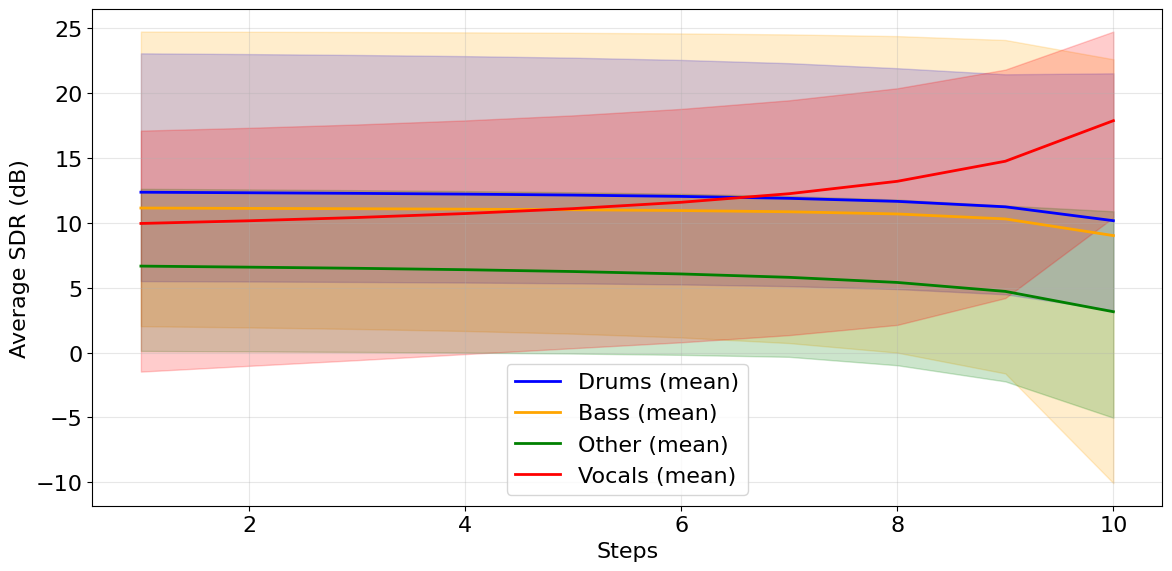

In [78]:
sdr_mean = results[0]
sdr_min_max = results[2]

plot_sdr_results(sdr_mean, sdr_min_max)

## Remixing with previous-step-extracted-stem

In [123]:
# use the function to evaluate SDR across all the dataset using progressive inference
results_2 = sdr_across_dataset(
    dataset_dict,
    model,
    sample_rate,
    device,
    overlap=0.0,
    target_stem="vocals",
    steps=10,
    mixture_update_mode="add sources",
    initial_gains={"bass": 1, "drums": 1, "vocals": 1, "other": 1},
    schedule_type="linear",
)


  0%|          | 0/50 [00:02<?, ?it/s]


KeyboardInterrupt: 

Average SDR results per stem: tensor([[ 12.3664,  11.1460,   6.6668,   9.9556],
        [ 12.2062,  11.0141,   6.5393,   9.8751],
        [ 11.9463,  10.7832,   6.2658,   9.7505],
        [ 11.5386,  10.3920,   5.7560,   9.5932],
        [ 10.8411,   9.5034,   4.8025,   9.4408],
        [  9.5558,   5.6393,   2.9141,   9.3208],
        [  6.1143,  -2.3706,  -0.6177,   9.2194],
        [-10.9051, -17.4832,  -7.7650,   9.1636],
        [-36.4365, -27.3048, -14.1258,   9.1394],
        [-37.8829, -29.3074, -16.5769,   9.1116]])


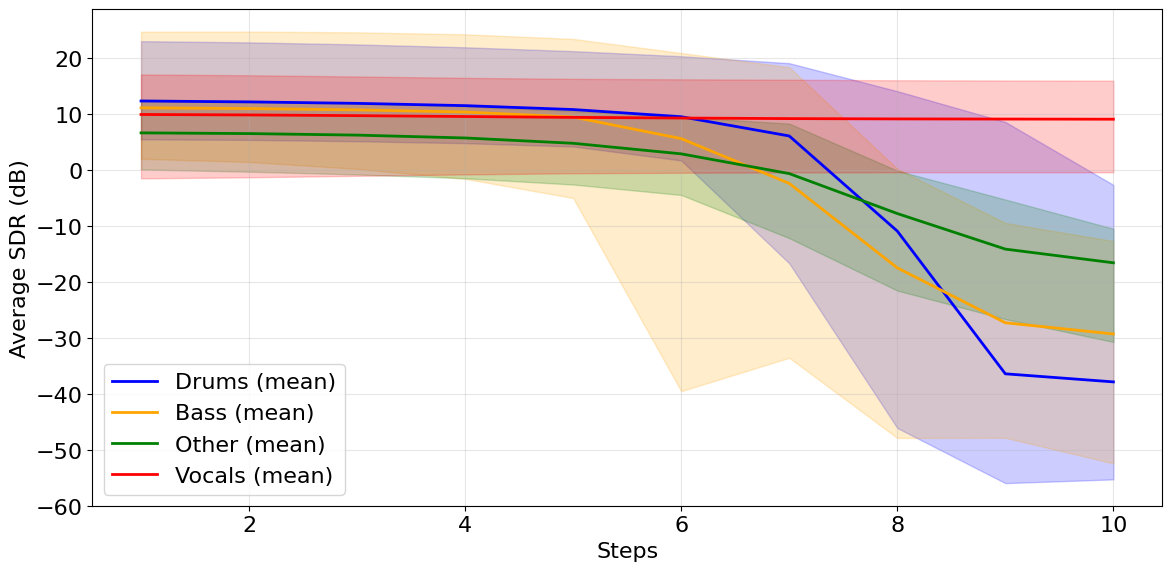

In [97]:
sdr_mean = results_2[0]
sdr_min_max = results_2[2]

plot_sdr_results(sdr_mean, sdr_min_max)

## Remixing adding the resulting target stem to the original mixture

### Vocals

In [124]:
# use the function to evaluate SDR across all the dataset using progressive inference
results_3 = sdr_across_dataset(
    dataset_dict,
    model,
    sample_rate,
    device,
    overlap=0.0,
    target_stem="vocals",
    steps = 10,
    mixture_update_mode="add to mixture",
    # display_first_output=True,  # Display output for the first track only
)

100%|██████████| 50/50 [06:46<00:00,  8.13s/it]


Average SDR results per stem: tensor([[12.3664, 11.1460,  6.6667,  9.9556],
        [12.3563, 11.1196,  6.6485,  9.9856],
        [12.3381, 11.0828,  6.6127,  9.9972],
        [12.3070, 11.0298,  6.5516,  9.9876],
        [12.2555, 10.9479,  6.4519,  9.9502],
        [12.1702, 10.8048,  6.2855,  9.8758],
        [12.0206, 10.5281,  6.0080,  9.7609],
        [11.7247,  9.9961,  5.5409,  9.6051],
        [11.1168,  7.9353,  4.5685,  9.4160],
        [ 9.2197,  2.0959,  2.0961,  9.2088]])


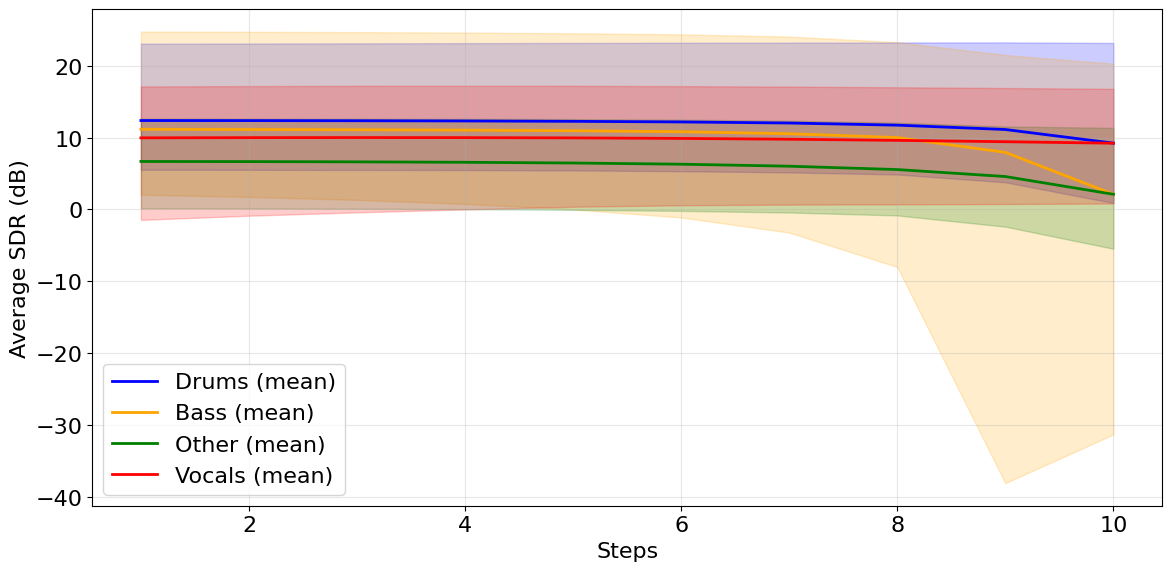

In [125]:
sdr_mean = results_3[0]
sdr_min_max = results_3[2]

plot_sdr_results(sdr_mean, sdr_min_max)

In [126]:
results_3[0] - results_3[3] 

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  8.9598e-04, -4.7684e-07,  0.0000e+00],
        [-9.5367e-07,  8.7619e-04, -2.3842e-07,  0.0000e+00]])

Average SDR results per stem: tensor([[12.3664, 11.1460,  6.6667,  9.9556],
        [12.3563, 11.1196,  6.6485,  9.9856],
        [12.3381, 11.0828,  6.6127,  9.9972],
        [12.3070, 11.0298,  6.5516,  9.9876],
        [12.2555, 10.9477,  6.4513,  9.9503],
        [12.1702, 10.8048,  6.2855,  9.8758],
        [12.0206, 10.5280,  6.0080,  9.7609],
        [11.7247,  9.9961,  5.5409,  9.6051],
        [11.1168,  7.9339,  4.5682,  9.4160],
        [ 9.2196,  2.0951,  2.0960,  9.2087]])


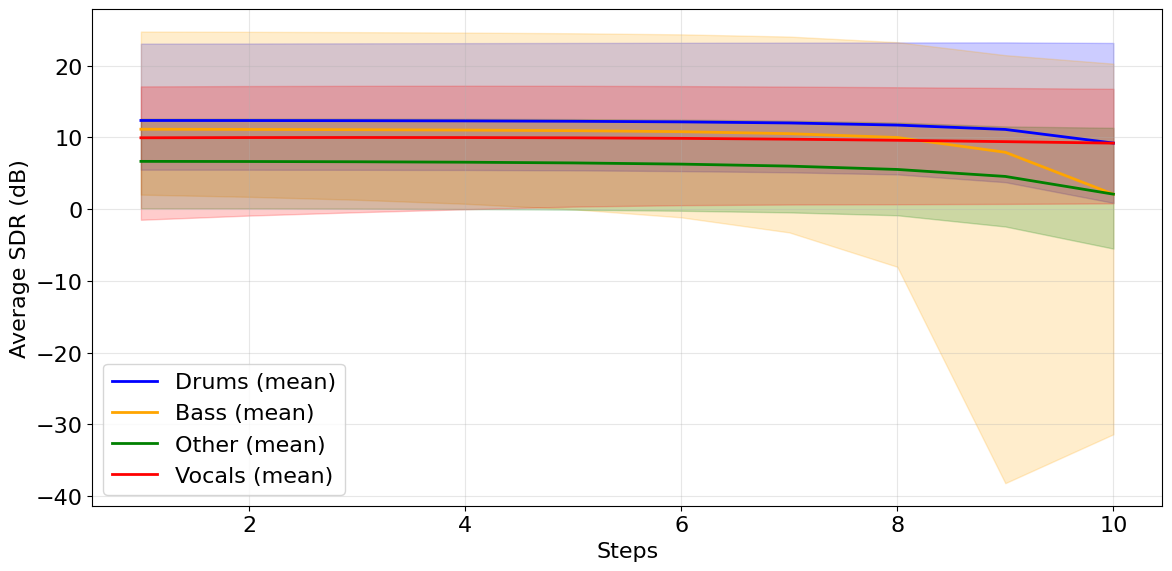

In [121]:
sdr_mean = results_3[3]
sdr_min_max = results_3[5]

plot_sdr_results(sdr_mean, sdr_min_max)

### Drums

In [ ]:
results_4 = sdr_across_dataset(
    dataset_dict,
    model,
    sample_rate,
    device,
    overlap=0.0,
    target_stem="drums",
    steps = 10,
    mixture_update_mode="add to mixture",
)

  6%|▌         | 3/50 [00:21<05:29,  7.02s/it]


ValueError: Audio clipping detected (max amplitude: 1.0504). Execution blocked to prevent distortion.

In [ ]:
sdr_mean = results_4[0]
sdr_min_max = results_4[2]

plot_sdr_results(sdr_mean, sdr_min_max)

NameError: name 'results_4' is not defined

### Bass

In [ ]:
results_5 = sdr_across_dataset(
    dataset_dict,
    model,
    sample_rate,
    device,
    overlap=0.0,
    target_stem="bass",
    steps = 10,
    mixture_update_mode="add to mixture",
)

100%|██████████| 50/50 [04:29<00:00,  5.40s/it]


Average SDR results per stem: tensor([[12.3664, 11.1460,  6.6667,  9.9556],
        [12.3562, 11.2597,  6.6631,  9.9388],
        [12.3301, 11.3422,  6.6400,  9.9151],
        [12.2818, 11.3887,  6.5919,  9.8818],
        [12.2011, 11.3994,  6.5115,  9.8327],
        [12.0560, 11.3631,  6.3812,  9.7549],
        [11.7890, 11.2677,  6.1683,  9.6240],
        [11.2693, 11.1071,  5.7844,  9.3823],
        [10.0411, 10.8706,  4.9711,  8.7978],
        [ 5.0914, 10.5686,  2.7593,  7.0791]])
Standard deviation of SDR results per stem: tensor([[3.8711, 4.7480, 2.7201, 3.5867],
        [3.8777, 4.6797, 2.7480, 3.5891],
        [3.8849, 4.6341, 2.7794, 3.5895],
        [3.8926, 4.6057, 2.8168, 3.5872],
        [3.9012, 4.5800, 2.8640, 3.5841],
        [3.9220, 4.5522, 2.9251, 3.5840],
        [3.9775, 4.5174, 3.0044, 3.5888],
        [4.1048, 4.4737, 3.1230, 3.6139],
        [4.5354, 4.4231, 3.3476, 3.9769],
        [6.9568, 4.3880, 3.8162, 5.3611]])


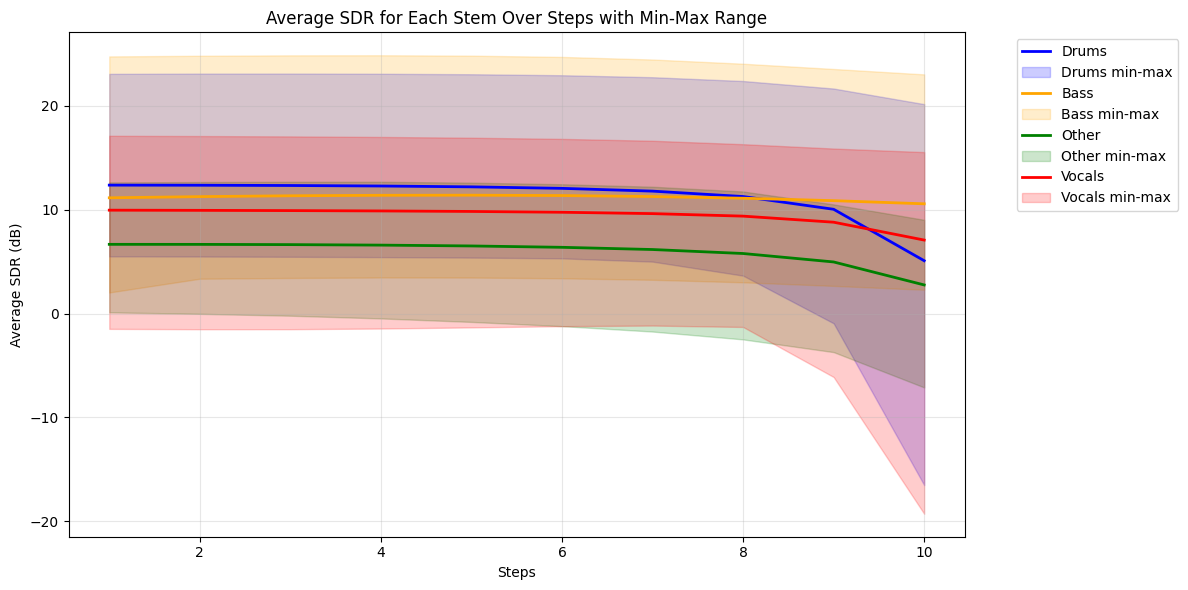

In [ ]:
sdr_mean = results_5[0]
sdr_min_max = results_5[2]

plot_sdr_results(sdr_mean, sdr_min_max)

### Other

In [ ]:
results_6 = sdr_across_dataset(
    dataset_dict,
    model,
    sample_rate,
    device,
    overlap=0.0,
    target_stem="other",
    steps = 10,
    mixture_update_mode="add to mixture",
)

100%|██████████| 50/50 [04:31<00:00,  5.43s/it]


Average SDR results per stem: tensor([[12.3664, 11.1460,  6.6667,  9.9556],
        [12.3547, 11.0916,  6.6947,  9.9408],
        [12.3271, 11.0071,  6.7040,  9.8982],
        [12.2779, 10.8741,  6.6869,  9.8217],
        [12.1933, 10.6859,  6.6383,  9.6996],
        [12.0396, 10.3801,  6.5471,  9.5023],
        [11.7477,  9.7822,  6.3953,  9.1481],
        [11.2469,  8.6507,  6.1650,  8.4433],
        [ 9.9162,  6.1114,  5.8328,  7.0018],
        [ 6.1495, -1.4520,  5.4704,  1.7666]])
Standard deviation of SDR results per stem: tensor([[ 3.8711,  4.7480,  2.7201,  3.5867],
        [ 3.8812,  4.8040,  2.6875,  3.6114],
        [ 3.8972,  4.8764,  2.6529,  3.6582],
        [ 3.9215,  4.9805,  2.6174,  3.7303],
        [ 3.9609,  5.0909,  2.5874,  3.8204],
        [ 4.0344,  5.2551,  2.5683,  3.9314],
        [ 4.1852,  5.5964,  2.5555,  4.1238],
        [ 4.4356,  6.0276,  2.5426,  4.3974],
        [ 5.1104,  7.3740,  2.5400,  4.5782],
        [ 7.4539, 11.4014,  2.5077,  7.1017]])


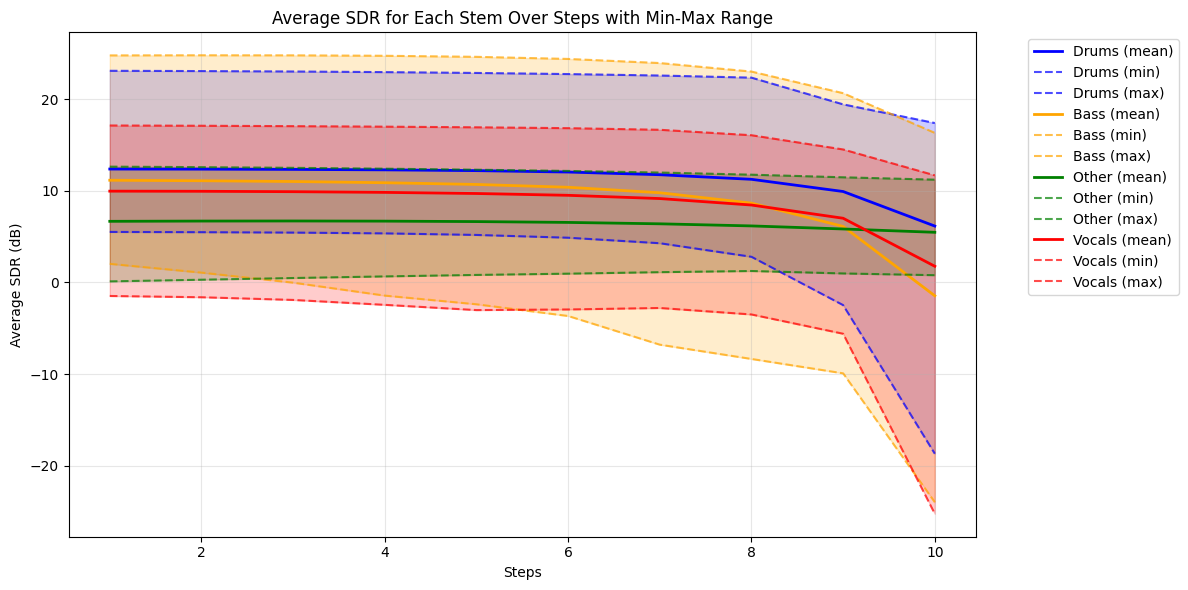

In [ ]:
sdr_mean = results_6[0]
sdr_min_max = results_6[2]

plot_sdr_results(sdr_mean, sdr_min_max)

## Data Driven Approach
##### Finds the optimal betas for the iterative shedule

<b> `save_stems_to_disk` </b>
This function saves separated audio stems to disk. It creates the specified directory (`save_dir`) if it does not exist, iterates through the `stems_dict` dictionary containing stem names and their corresponding waveforms, and saves each waveform as a `.wav` file using `torchaudio.save`.


<b> `load_stems_from_disk` </b>
This function loads separated audio stems from disk. It iterates through a predefined list of stem names (`drums`, `bass`, `other`, `vocals`) and attempts to load each stem's waveform from the specified `track_path`. If a file exists, it loads the waveform using `torchaudio.load` and moves it to the specified `device`. Missing files are logged as warnings.


<b> `optimal_beta_schedule` </b>
This function performs progressive inference to optimize the beta parameter for enhancing the separation of a target stem (`target_stem`). The procedure is as follows:
1. **Initialization**: Generate a range of beta values (`beta_values`) and create directories for saving output tracks if `save_to_disk` is enabled.
2. **Step 0**: Perform source separation on the original mixture (`new_mixture`) for all tracks in `dataset_dict`. Compute SDR values for each stem and save the separated stems to disk if required.
3. **Steps 1 to N**:
    - For each step, iterate through the beta values to find the optimal beta that maximizes the SDR for the target stem.
    - For each beta, create a new mixture by blending the original mixture and the target stem using the beta value. Perform source separation on the new mixture and compute SDR values for the target stem.
    - Track the best beta and corresponding separated sources for each track.
    - Save the separated stems to disk and compute average SDR values for all stems.
4. **Early Stopping**: Stop the process if the SDR for the target stem does not improve compared to the previous step.
5. **Return Results**: Return the optimal beta values and stepwise SDR values.


In [ ]:
def save_stems_to_disk(stems_dict, save_dir, sample_rate):
    """Save separated tracks to disk."""
    os.makedirs(save_dir, exist_ok=True)
    for stem_name, waveform in stems_dict.items():
        file_path = os.path.join(save_dir, f"{stem_name}.wav")
        torchaudio.save(file_path, waveform.cpu(), sample_rate=sample_rate)

def load_stems_from_disk(track_path, device):
    """Load separated tracks from disk."""
    stems_dict = {}
    for stem_name in ["drums", "bass", "other", "vocals"]:
        file_path = os.path.join(track_path, f"{stem_name}.wav")
        if os.path.isfile(file_path):
            waveform, _ = torchaudio.load(file_path)
            stems_dict[stem_name] = waveform.to(device)
        else:
            print(f"Warning: file not found {file_path}")
    return stems_dict

def optimal_beta_schedule(
        model,
        dataset_dict,
        sample_rate,
        overlap,
        device,
        steps,
        target_stem="vocals",
        precision=None,
        normalize=True,
        wiener_filter=False,
        save_to_disk=True):

    beta_values = np.linspace(0, 1, precision)[1:]
    save_dir = "output_tracks"
    if save_to_disk:
        os.makedirs(save_dir, exist_ok=True)

    optimal_betas = np.zeros(steps)
    stepwise_sdrs = [torch.zeros(4) for _ in range(steps + 1)]

    # Step 0
    print("Step 0")
    sdr_collection = []
    for track_name, stems_dict in tqdm(dataset_dict.items()):
        if "new_mixture" not in stems_dict:
            print(f"Skipping track {track_name} as it does not contain a new mixture.")
            continue

        mixture = stems_dict["new_mixture"].to(device).unsqueeze(0)
        separated_sources = separate_sources(model, mixture, sample_rate, overlap, device, normalize)
        sdr_results = compute_sdrs(model, device, stems_dict, separated_sources)

        stems_dict_out = {stem_name: separated_sources[0, i].cpu() for i, stem_name in enumerate(model.sources)}
        if save_to_disk:
            track_save_path = os.path.join(save_dir, "step_0", track_name)
            save_stems_to_disk(stems_dict_out, track_save_path, sample_rate)

        sdr_step0_tensor = torch.tensor([sdr_results[stem][0] for stem in model.sources])
        sdr_collection.append(sdr_step0_tensor)

    stepwise_sdrs[0] = torch.mean(torch.stack(sdr_collection), dim=0)
    print(f"Step 0 SDR mean value for {target_stem}: {stepwise_sdrs[0]}")

    # Steps 1 to N
    for number_of_step in range(1, steps + 1):
        print(f"------------Step {number_of_step}------------")
        best_sdr_value = -np.inf
        best_beta = None
        best_estimates_all = {}
        target_index = model.sources.index(target_stem)

        for beta in beta_values:
            sdr_values_list = []
            current_estimates_all = {}

            for track_name, stems_dict in tqdm(dataset_dict.items()):
                if "new_mixture" not in stems_dict:
                    print(f"Skipping track {track_name} as it does not contain a new mixture.")
                    continue

                if save_to_disk:
                    track_path = os.path.join(save_dir, f"step_{number_of_step - 1}", track_name)
                    prev_stems_dict = load_stems_from_disk(track_path, device)
                    target_track = prev_stems_dict[target_stem].to(device)
                else:
                    target_track = stems_dict[target_stem].to(device)

                mixture = stems_dict["new_mixture"].to(device).unsqueeze(0)
                new_mix = mixture * (1 - beta) + target_track * beta
                new_mix = new_mix / new_mix.abs().max()

                separated_sources = separate_sources(model, new_mix, sample_rate, overlap, device, normalize)
                if wiener_filter:
                    separated_sources[:, target_index] = wiener_filtering(separated_sources, new_mix, target_index)

                predicted_stem = separated_sources[0, target_index].to(device)
                original_stem = stems_dict[target_stem].to(device)
                sdr_value_target_stem = evaluate_sdr(original_stem, predicted_stem, device=device)
                sdr_values_list.append(sdr_value_target_stem)

                current_estimates_all[track_name] = separated_sources

            mean_sdr = torch.mean(torch.tensor(sdr_values_list))

            if mean_sdr > best_sdr_value:
                best_sdr_value = mean_sdr
                best_beta = beta
                best_estimates_all = current_estimates_all

        print(f"New best SDR value found at {number_of_step} with beta = {best_beta} is {best_sdr_value}")
        optimal_betas[number_of_step - 1] = best_beta

        # Final calculation of averages using best_estimates_all
        sdr_collection = []
        for track_name, stems_dict in dataset_dict.items():
            if "new_mixture" not in stems_dict or track_name not in best_estimates_all:
                continue

            separated_sources = best_estimates_all[track_name]
            sdr_results = compute_sdrs(model, stems_dict, separated_sources, device)

            if save_to_disk:
                stems_dict_out = {stem_name: separated_sources[0, i].cpu() for i, stem_name in enumerate(model.sources)}
                track_save_path = os.path.join(save_dir, f"step_{number_of_step}", track_name)
                save_stems_to_disk(stems_dict_out, track_save_path, sample_rate)

            sdr_collection.append(torch.tensor([sdr_results[stem][0] for stem in model.sources]))

        if len(sdr_collection) > 0:
            stepwise_sdrs[number_of_step] = torch.mean(torch.stack(sdr_collection), dim=0)
            print(f"Step {number_of_step} SDR mean values: {stepwise_sdrs[number_of_step]}")

        # Early stopping
        if stepwise_sdrs[number_of_step][target_index] <= stepwise_sdrs[number_of_step - 1][target_index]:
            print(f"Stopping early at step {number_of_step} as SDR did not improve.")
            return optimal_betas, stepwise_sdrs

    return optimal_betas, stepwise_sdrs

In [ ]:
steps = 10 # number of iterations
precision = 11 # precision of the beta values: in how many beta values we want to divide the range

optimal_betas, stepwise_sdrs = optimal_beta_schedule(
        model = model,
        dataset_dict = dataset_dict,
        target_stem = "vocals",
        sample_rate = sample_rate,
        overlap = 0.0,
        device = device,
        steps = steps,
        precision=precision
        )

Step 0


100%|██████████| 50/50 [00:40<00:00,  1.23it/s]


Step 0 SDR mean value for vocals: tensor([12.3664, 11.1460,  6.6667,  9.9556])
------------Step 1------------


100%|██████████| 50/50 [00:38<00:00,  1.31it/s]


New best SDR value found at 1 with beta = 0.8 is 10.025650978088379
Step 1 SDR mean values: tensor([11.0499,  7.7920,  4.3892, 10.0257])
------------Step 2------------


100%|██████████| 50/50 [00:38<00:00,  1.29it/s]


New best SDR value found at 2 with beta = 0.1 is 10.021869659423828
Step 2 SDR mean values: tensor([12.3376, 11.0931,  6.6226, 10.0219])
Stopping early at step 2 as SDR did not improve.


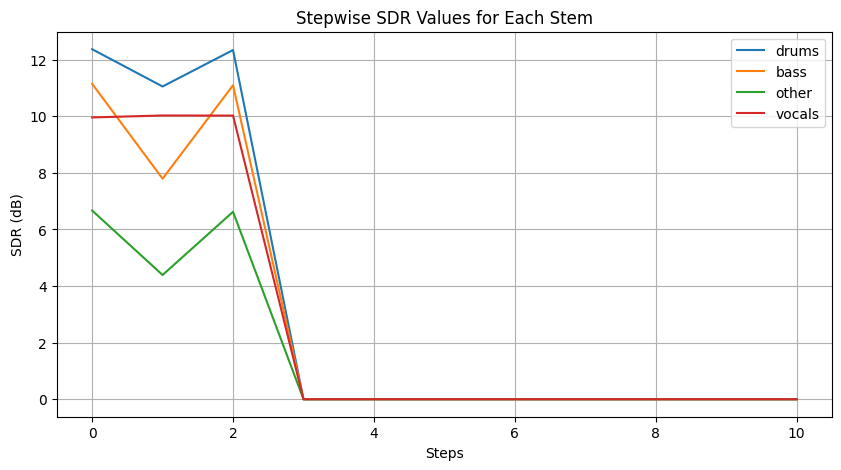

In [ ]:
def plot_stepwise_sdrs(stepwise_sdrs, stems):
    """
    Plot the SDR values for each stem across steps.

    Args:
        stepwise_sdrs (list): List of tensors containing SDR values for each step.
        stems (list): List of stem names.
    """
    steps = np.arange(len(stepwise_sdrs))
    sdr_values = torch.stack(stepwise_sdrs).cpu().numpy()

    plt.figure(figsize=(10, 5))
    for i, stem in enumerate(stems):
        plt.plot(steps, sdr_values[:, i], label=stem)

    plt.xlabel('Steps')
    plt.ylabel('SDR (dB)')
    plt.title('Stepwise SDR Values for Each Stem')
    plt.legend()
    plt.grid()
    plt.show()

# Define the stems based on the model sources
stems = model.sources

# Plot the stepwise SDR values
plot_stepwise_sdrs(stepwise_sdrs, stems)